<img style="float: left" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width ="110px"/>


 # <p style="text-align: center">  <font color = 'darkblue'> PAP - Predicción de consumo de energía en días festivos
    
 ### <p style="text-align: center">  <font color = 'darkblue'> Consumo horario

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#from xlrd.xldate import xldate_as_tuple
import numpy as np
import datetime
from datetime import timedelta
from calendar import monthrange
from datetime import datetime
import scipy as sp
from pandas import Series
from numpy import polynomial
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import itertools
import sklearn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
df = pd.read_excel("Consumo horario GCROC 1997-2020.xlsx") #leyendo los datos

In [3]:
df.columns = df.iloc[0,:]
df = df.dropna(axis='columns', how='all')

In [4]:
df1= pd.DataFrame(list(df['(MWh)']))
df1 = df1.dropna()
df1.columns = ['MWh']
df1 = df1.drop(axis =1, index = 0)
#df1 = df1.drop(axis =1, index = 1)
dates = list(datetime(1997, 1, 1, 0, 0)+ timedelta(hours=i) for i in range(203304))
df1.index = dates


In [5]:
dates = pd.read_csv("fechas.csv")
dates['Fecha'] = pd.to_datetime(dates['Fecha']) 
dates = dates.set_index("Fecha")

names = ['año nuevo','aniversario de la Constitución de 1917','natalicio de Benito Juárez Garcia',
        'jueves santo','viernes santo','día del trabajo',
        'día de la madre','día de la Independencia',
        'día de la Virgen de Zapopan','día de los muertos',
        'día de la Revolución','día de la Virgen de Guadalupe',
        'Navidad']

errores = pd.DataFrame(index = ['Regresión lineal Consumo','Regresión lineal Consumo (MCO)',
                                'Regresión lineal multivar','Regresión lineal multivar (MCO)','SARIMA'],columns = names)

In [6]:
pred_lr1 = pd.DataFrame(columns = names)
pred_lr2 = pd.DataFrame(columns = names)
pred_lr3 = pd.DataFrame(columns = names)
pred_lr4 = pd.DataFrame(columns = names)

In [7]:
fechas = list(dates.index)
test= pd.to_datetime(fechas[0])
temp = list(list(fechas[j]+ timedelta(hours=i) for i in range(24)) for j in range(307))
temp2 = list(itertools.chain.from_iterable(temp))
fec = pd.DataFrame(index = list(temp2), columns = ['Day']) 
temp3 = list(dates['Conmemoracion'])
k = list(list(temp3[j] for i in range(24)) for j in range(307))
temp4 = list(itertools.chain.from_iterable(k))
fec['Day'] = temp4


In [8]:
data = df1.join(fec)
data = data.dropna()

In [9]:
comp = pd.read_excel('Consumo GCROC 2002-2019-2.xlsx', 'datos' ,usecols='B:J')
comp.columns = ['MWh', 'Temp min', 'Temp max', 'Temp prom',
               'borrar','borrar1','Vel viento', 'dia sem']
comp =comp.drop(['borrar','borrar1'], axis =1)
comp =comp.drop('fecha',axis = 0)

In [10]:
ind = list(comp.index)
temp =list(list(ind[j]+ timedelta(hours=i) for i in range(24)) for j in range(len(ind)))
temp2 = list(itertools.chain.from_iterable(temp))
temp = pd.DataFrame(index = list(temp2), columns = ['Temp prom', 'Vel viento', 'dia sem','Cons total']) 
temp3 = list(comp['Temp prom'])
k = list(list(temp3[j] for i in range(24)) for j in range(len(comp)))
temp4 = list(comp['Vel viento'])
l = list(list(temp4[j] for i in range(24)) for j in range(len(comp)))
temp5 = list(comp['dia sem'])
m = list(list(temp5[j] for i in range(24)) for j in range(len(comp)))
temp6 = list(comp['MWh'])
n = list(list(temp6[j] for i in range(24)) for j in range(len(comp)))
temp['Temp prom'] = list(itertools.chain.from_iterable(k))
temp['Vel viento'] = list(itertools.chain.from_iterable(l))
temp['dia sem'] = list(itertools.chain.from_iterable(m))
temp['Cons total'] = list(itertools.chain.from_iterable(n))

df_av = data.join(temp)
df_av = df_av.dropna()
#df_av.iloc[:,2:7]

## <p style="text-align: center"> Proyecciones

## <p style="text-align: center"> Regresión lineal

In [11]:
def consumo_24h(mes):
    consumo_ =pd.DataFrame()
    if dates['Conmemoracion'][mes] == names[mes]:
        month= dates.index[mes].month
        day = dates.index[mes].day
        nn= monthrange(2002, month)
        n = nn[1]
    if day <=1:
        _day = n
        month = 12
    else: 
        _day = day - 1
    z = list(df1[(df1.index.month == month) & (df1.index.day == _day)]['MWh'])
    return z

In [12]:
def consumo_1h(df):
    hrs = list(df.index[i] - timedelta(hours=1) for i in range(len(df))) 
    k = df1[df1.index.isin(hrs)]
    return k['MWh'].tolist()

In [13]:
def reg_cons(df,name):
    ndat= int(np.round(0.80*len(df)))
    X = df.iloc[:,1:3]
    Y = df.iloc[:,0]
    
    Xtrain = X.iloc[0:ndat,:]
    Xtest = X.iloc[ndat:,:]
    Ytrain = Y.iloc[0:ndat]
    Ytest = Y.iloc[ndat:]
    
    lm = linear_model.LinearRegression()
    lm.fit(Xtrain, Ytrain)
    
    Y_pred = lm.predict(Xtest)
    
    errores[name]['Regresión lineal Consumo'] = abs(np.mean((Ytest-Y_pred)/Ytest))
    pred_lr1[name]=Y_pred[:110]
    
    print('Coefficients: \n', lm.coef_)
    print('Intercept: \n', lm.intercept_)

    X = sm.add_constant(X) # agregar una constante
    Ytrain = list(Ytrain)
    temporal= np.asarray(Xtrain)
    Xtrain = temporal.tolist()
    temporal2= np.asarray(Xtest)
    Xtest = temporal2.tolist()
 

    model0 = sm.OLS(Ytrain, Xtrain).fit()
    predictions0 = model0.predict(Xtest) 
    
    errores[name]['Regresión lineal Consumo (MCO)'] = abs(np.mean((Ytest-predictions0)/Ytest))
    pred_lr2[name]= predictions0[:110]

    print_model0 = model0.summary()
    #print(print_model0)
   

In [14]:
def reg_av(df,name):
    ndat= int(np.round(0.80*len(df)))
    X = df.iloc[:,1:8]
    Y = df.iloc[:,0]
    
    Xtrain = X.iloc[0:ndat,:]
    Xtest = X.iloc[ndat:,:]
    Ytrain = Y.iloc[0:ndat]
    Ytest = Y.iloc[ndat:]
    
    lm = linear_model.LinearRegression()
    lm.fit(Xtrain, Ytrain)
    
    Y_pred = lm.predict(Xtest)
    
    errores[name]['Regresión lineal multivar'] = abs(np.mean((Ytest-Y_pred)/Ytest))
    
    print('Coefficients: \n', lm.coef_)
    print('Intercept: \n', lm.intercept_)

    X = sm.add_constant(X) # agregar una constante
    Ytrain = list(Ytrain)
    temporal= np.asarray(Xtrain)
    Xtrain = temporal.tolist()
    temporal2= np.asarray(Xtest)
    Xtest = temporal2.tolist()
 

    model0 = sm.OLS(Ytrain, Xtrain).fit()
    predictions0 = model0.predict(Xtest) 
    
    errores[name]['Regresión lineal multivar (MCO)'] = abs(np.mean((Ytest-predictions0)/Ytest))
    
    pred_lr3[name]= Y_pred[:82]
    pred_lr4[name]= predictions0[:82]

    print_model0 = model0.summary()
    #print(print_model0)
    return 


#### <p style="text-align: center">  <font color = 'red'> Año Nuevo

In [15]:
a_nuevo = data[(data.Day == names[0])].drop(['Day'], axis =1)
a_nuevo['Consumo -24h'] = list(consumo_24h(0))
a_nuevo = a_nuevo.drop(a_nuevo.index[0])
a_nuevo['Consumo -1h'] = consumo_1h(a_nuevo)
an2 = df_av[(df_av.Day == names[0])].drop(['Day'], axis =1)
p=consumo_24h(0)
an2['Consumo -24h'] = list(p[120:])
an2['Consumo -1h'] = consumo_1h(an2)

In [16]:
reg_cons(a_nuevo,'año nuevo')

Coefficients: 
 [0.18528004 0.82800103]
Intercept: 
 -241.54946806915905


In [17]:
reg_av(an2,'año nuevo')

Coefficients: 
 [-4.69563407e+01 -7.66811269e+00 -2.40265214e+00 -5.34826643e-03
  3.15013834e-01  8.70832403e-01]
Intercept: 
 459.0641864700724


#### <p style="text-align: center">  <font color = 'red'> Aniversario de la Constitución de 1917

In [18]:
a_const = data[(data.Day == names[1])].drop(['Day'], axis =1)
k = list(consumo_24h(1))
a_const['Consumo -24h'] = k[0:552]
a_const['Consumo -1h'] = consumo_1h(a_const)
ac2 = df_av[(df_av.Day == names[1])].drop(['Day'], axis =1)
p=consumo_24h(1)
ac2['Consumo -24h'] = list(p[144:])
ac2['Consumo -1h'] = consumo_1h(ac2)

In [19]:
reg_cons(a_const,'aniversario de la Constitución de 1917')

Coefficients: 
 [0.07992486 0.93135246]
Intercept: 
 -37.27732017568542


In [20]:
reg_av(ac2,'aniversario de la Constitución de 1917')

Coefficients: 
 [ 5.97504971e+01 -1.91861393e-01 -3.27854579e+01  2.20376876e-03
  2.02806657e-01  7.88455909e-01]
Intercept: 
 -1449.6064975115596


#### <p style="text-align: center">  <font color = 'red'> Natalicio de Benito Juárez García

In [21]:
nb = data[(data.Day == names[2])].drop(['Day'], axis =1)
nb['Consumo -24h'] = list(consumo_24h(2))
nb['Consumo -1h'] = consumo_1h(nb)
nb2 = df_av[(df_av.Day == names[2])].drop(['Day'], axis =1)
p=consumo_24h(2)
#len(p)-len(nb2)
nb2['Consumo -24h'] = list(p[120:])
nb2['Consumo -1h'] = consumo_1h(nb2)

In [22]:
reg_cons(nb,'natalicio de Benito Juárez Garcia')

Coefficients: 
 [0.19248131 0.78563903]
Intercept: 
 35.098728166028195


In [23]:
reg_av(nb2,'natalicio de Benito Juárez Garcia')

Coefficients: 
 [ 1.31706203e+01  4.00520814e+00 -1.21743673e+01  5.30038074e-04
  1.63982318e-01  7.84924826e-01]
Intercept: 
 -200.3375908860935


#### <p style="text-align: center">  <font color = 'red'> Jueves Santo

In [24]:
js = data[(data.Day == names[3])].drop(['Day'], axis =1)
js['Consumo -24h'] = list(consumo_24h(3))
js['Consumo -1h'] = consumo_1h(js)
js2 = df_av[(df_av.Day == names[3])].drop(['Day'], axis =1)
p=consumo_24h(3)
#len(p)-len(nb2)
js2['Consumo -24h'] = list(p[120:])
js2['Consumo -1h'] = consumo_1h(js2)

In [25]:
reg_cons(js,'jueves santo')

Coefficients: 
 [0.13277381 0.86423895]
Intercept: 
 -42.4989102306763


In [26]:
reg_av(js2, 'jueves santo')

Coefficients: 
 [-1.61096142e+00 -4.59566354e+00  2.13657912e+01  6.84271144e-03
  1.40590153e-01  7.28444920e-01]
Intercept: 
 -180.57315410870706


#### <p style="text-align: center">  <font color = 'red'> Viernes Santo

In [27]:
vs= data[(data.Day == names[4])].drop(['Day'], axis =1)
vs['Consumo -24h'] = list(consumo_24h(4))
vs['Consumo -1h'] = consumo_1h(vs)

vs2 = df_av[(df_av.Day == names[4])].drop(['Day'], axis =1)
p=consumo_24h(4)
#len(p)-len(nb2)
vs2['Consumo -24h'] = list(p[120:])
vs2['Consumo -1h'] = consumo_1h(vs2)

In [28]:
reg_cons(vs,'viernes santo')

Coefficients: 
 [0.0913149  0.92052995]
Intercept: 
 -148.2932665907183


In [29]:
reg_av(vs2,'viernes santo')

Coefficients: 
 [-3.15657891e+00 -9.66799439e+00 -2.15145502e+01  5.59981705e-03
  1.14823010e-01  7.91832186e-01]
Intercept: 
 96.77214486070716


#### <p style="text-align: center">  <font color = 'red'> Día del trabajo

In [30]:
dt= data[(data.Day == names[5])].drop(['Day'], axis =1)
k = list(consumo_24h(5))
dt['Consumo -24h'] = k[0:552]
dt['Consumo -1h'] = consumo_1h(dt)

dt2 = df_av[(df_av.Day == names[5])].drop(['Day'], axis =1)
p=consumo_24h(5)
#len(p)-len(nb2)
dt2['Consumo -24h'] = list(p[144:])
dt2['Consumo -1h'] = consumo_1h(dt2)

In [31]:
reg_cons(dt,'día del trabajo')

Coefficients: 
 [0.18438163 0.80875086]
Intercept: 
 51.40018507836339


In [32]:
reg_av(dt2,'día del trabajo')

Coefficients: 
 [-5.94316359e+00 -7.21485864e+00  4.40542846e+00  4.08864544e-03
  2.07435083e-01  7.47090404e-01]
Intercept: 
 -41.30911714656668


#### <p style="text-align: center">  <font color = 'red'> Día de la madre

In [33]:
dm= data[(data.Day == names[6])].drop(['Day'], axis =1)
dm['Consumo -24h'] = list(consumo_24h(6))
dm['Consumo -1h'] = consumo_1h(dm)

dm2 = df_av[(df_av.Day == names[6])].drop(['Day'], axis =1)
p=consumo_24h(6)
dm2['Consumo -24h'] = list(p[(len(p)-len(dm2)):])
dm2['Consumo -1h'] = consumo_1h(dm2)

In [34]:
reg_cons(dm,'día de la madre')

Coefficients: 
 [0.16415997 0.83520005]
Intercept: 
 0.28698423260993877


In [35]:
reg_av(dm2,'día de la madre')

Coefficients: 
 [ 3.58057573e+01 -7.15060782e+00  4.78883071e+00  4.07460121e-03
  2.26724988e-01  7.31794057e-01]
Intercept: 
 -1026.969772888221


#### <p style="text-align: center">  <font color = 'red'> Día de la Independencia

In [36]:
di= data[(data.Day == names[7])].drop(['Day'], axis =1)
di['Consumo -24h'] = list(consumo_24h(7))
di['Consumo -1h'] = consumo_1h(di)

di2 = df_av[(df_av.Day == names[7])].drop(['Day'], axis =1)
p=consumo_24h(7)
di2['Consumo -24h'] = list(p[(len(p)-len(di2)):])
di2['Consumo -1h'] = consumo_1h(di2)

In [37]:
reg_cons(di,'día de la Independencia')

Coefficients: 
 [0.22249654 0.74490753]
Intercept: 
 9.952282232350626


In [38]:
reg_av(di2,'día de la Independencia')

Coefficients: 
 [-1.57427726e+00 -7.40912348e-01 -2.16149269e+01 -2.06937158e-05
  2.28442332e-01  7.44355827e-01]
Intercept: 
 115.48859819772952


#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Zapopan

In [39]:
dvz= data[(data.Day == names[8])].drop(['Day'], axis =1)
dvz['Consumo -24h'] = list(consumo_24h(8))
dvz['Consumo -1h'] = consumo_1h(dvz)

dvz2 = df_av[(df_av.Day == names[8])].drop(['Day'], axis =1)
p=consumo_24h(8)
dvz2['Consumo -24h'] = list(p[(len(p)-len(dvz2)):])
dvz2['Consumo -1h'] = consumo_1h(dvz2)

In [40]:
reg_cons(dvz,'día de la Virgen de Zapopan')

Coefficients: 
 [0.17679078 0.82410977]
Intercept: 
 10.062384173336795


In [41]:
k =reg_av(dvz2,'día de la Virgen de Zapopan')

Coefficients: 
 [1.94495721e+01 1.54107359e+01 1.47832357e+01 3.52131214e-03
 3.83476161e-01 5.67184657e-01]
Intercept: 
 -1078.714767408509


#### <p style="text-align: center">  <font color = 'red'> Día de los muertos

In [42]:
dm= data[(data.Day == names[9])].drop(['Day'], axis =1)
k = list(consumo_24h(9))
dm['Consumo -24h'] = k[0:552]
dm['Consumo -1h'] = consumo_1h(dm)

dmu2 = df_av[(df_av.Day == names[9])].drop(['Day'], axis =1)
p=consumo_24h(9)
dmu2['Consumo -24h'] = list(p[(len(p)-len(dmu2)):])
dmu2['Consumo -1h'] = consumo_1h(dmu2)

In [43]:
reg_cons(dm,'día de los muertos')

Coefficients: 
 [0.18402605 0.82544901]
Intercept: 
 -39.52769609643656


In [44]:
reg_av(dmu2,'día de los muertos')

Coefficients: 
 [ 8.21391833e+00  1.12346448e+01 -1.11766105e+01  3.35167970e-03
  3.22258768e-01  6.46684833e-01]
Intercept: 
 -748.6724887706323


#### <p style="text-align: center">  <font color = 'red'> Día de la Revolución

In [45]:
dr= data[(data.Day == names[10])].drop(['Day'], axis =1)
dr['Consumo -24h'] = list(consumo_24h(10))
dr['Consumo -1h'] = consumo_1h(dr)

dr2 = df_av[(df_av.Day == names[10])].drop(['Day'], axis =1)
p=consumo_24h(10)
dr2['Consumo -24h'] = list(p[(len(p)-len(dr2)):])
dr2['Consumo -1h'] = consumo_1h(dr2)

In [46]:
reg_cons(dr,'día de la Revolución')

Coefficients: 
 [0.28861833 0.68075216]
Intercept: 
 7.968898214710862


In [47]:
reg_av(dr2,'día de la Revolución')

Coefficients: 
 [2.35415463e+00 5.33790572e+00 2.14204836e+01 2.78741699e-03
 2.38655088e-01 7.26723777e-01]
Intercept: 
 -586.0374601795247


#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Guadalupe

In [48]:
dvg= data[(data.Day == names[11])].drop(['Day'], axis =1)
dvg['Consumo -24h'] = list(consumo_24h(11))
dvg['Consumo -1h'] = consumo_1h(dvg)

dv2 = df_av[(df_av.Day == names[11])].drop(['Day'], axis =1)
p=consumo_24h(11)
dv2['Consumo -24h'] = list(p[(len(p)-len(dv2)):])
dv2['Consumo -1h'] = consumo_1h(dv2)

In [49]:
reg_cons(dvg,'día de la Virgen de Guadalupe')

Coefficients: 
 [0.22089887 0.74649156]
Intercept: 
 21.825725284512373


In [50]:
reg_av(dv2,'día de la Virgen de Guadalupe')

Coefficients: 
 [ 1.77940515e+00 -3.88040030e-01  1.46945804e+01  7.72327811e-03
  2.03408108e-01  6.12360632e-01]
Intercept: 
 -252.28342575211627


#### <p style="text-align: center">  <font color = 'red'> Navidad

In [51]:
nav= data[(data.Day == names[12])].drop(['Day'], axis =1)
nav['Consumo -24h'] = list(consumo_24h(12))
nav['Consumo -1h'] = consumo_1h(nav)

nav2 = df_av[(df_av.Day == names[12])].drop(['Day'], axis =1)
p=consumo_24h(12)
nav2['Consumo -24h'] = list(p[(len(p)-len(nav2)):])
nav2['Consumo -1h'] = consumo_1h(nav2)

In [52]:
reg_cons(nav,'Navidad')

Coefficients: 
 [0.19597767 0.81617541]
Intercept: 
 -237.40684961685884


In [53]:
reg_av(nav2,'Navidad')

Coefficients: 
 [ 2.49168296 -7.6939054  -0.25647692 -0.00930159  0.31440454  0.8883395 ]
Intercept: 
 -107.97490642035427


## <p style="text-align: center"> SARIMA


### <font color = 'blue'> A continuació 

In [54]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#### <p style="text-align: center">  <font color = 'red'> Año Nuevo

In [55]:
a_nuevo = data[(data.Day == names[0])].drop(['Day'], axis =1)

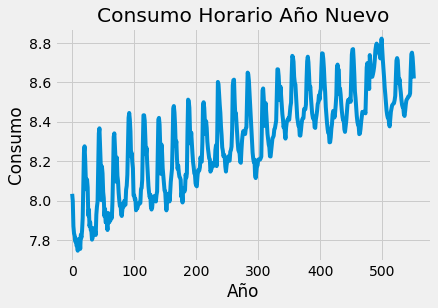

In [56]:
npa_nuevo = np.array(a_nuevo, dtype=float)
ndat = np.round(0.80*len(npa_nuevo))
series = np.log(npa_nuevo)
plt.plot(series)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Año Nuevo')
plt.show()

In [57]:
train =a_nuevo[0:int(ndat)]
test=a_nuevo[int(ndat):len(npa_nuevo)]

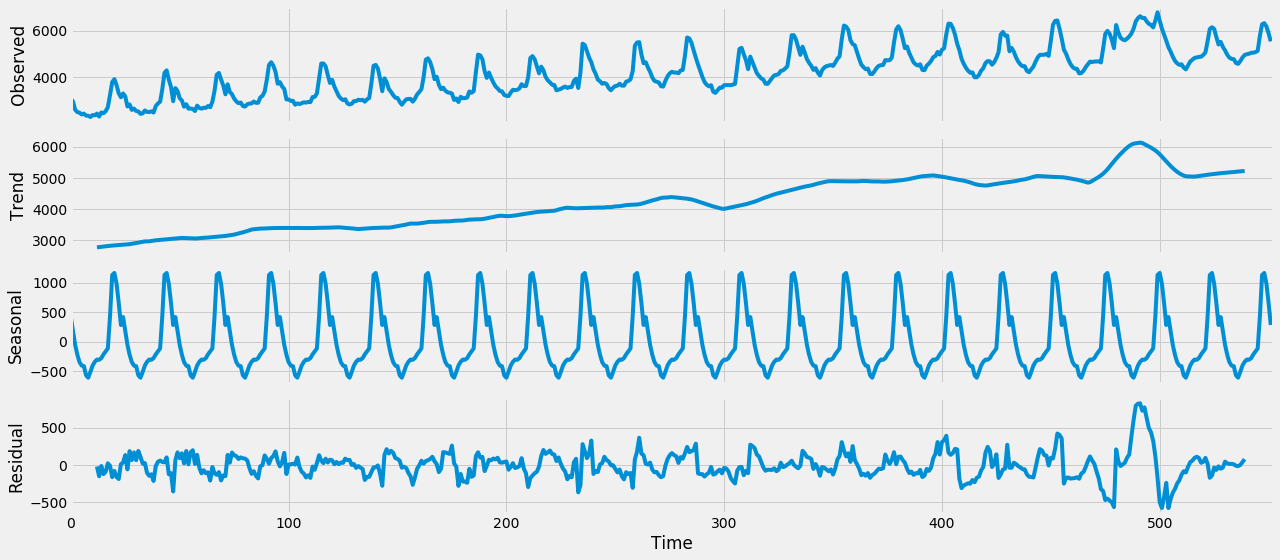

In [58]:

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npa_nuevo, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [59]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

In [29]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8576.812651591646
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7603.454085789997
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:5890.2462330892085
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:5555.021282366066
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:5843.916170160066
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:5749.8985961854
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:5566.270627750108
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:5550.4720568944995
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8236.776334873151
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7062.926776280348
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:5587.656498523418
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5250.635614068255
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:5574.902159108391
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5448.842589279284
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5271.105392136433
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5245.050183221529
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6151.725962413091
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5583.269580973888
ARIMA(0, 1

In [60]:
#ARIMA(1, 0, 1)x(1, 1, 1, 12)12
mod_an = sm.tsa.statespace.SARIMAX(np.array(train, dtype=float),
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_an = mod_an.fit()
results_an.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [61]:
#results.plot_diagnostics(figsize=(18, 8))
#plt.show()

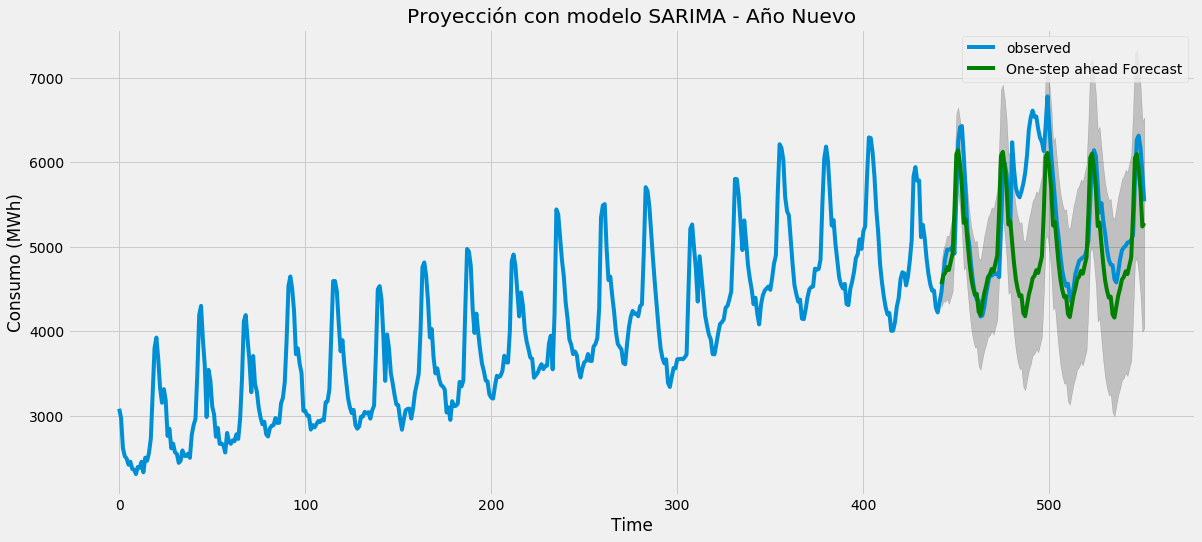

In [62]:
pred_an_1 = results_an.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_an_1.conf_int()
train_an = np.array(a_nuevo, dtype=float)
ax= plt.plot(train_an, label='observed')
pred_an= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_an['Forecast'] = pred_an_1.predicted_mean
plt.plot(pred_an,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_an.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Año Nuevo')
plt.legend()
plt.show()


In [63]:
errores[names[0]]['SARIMA'] = abs(np.mean((np.asarray(test['MWh'].tolist())-np.asarray(pred_an['Forecast'].tolist()))/np.asarray(pred_an['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Aniversario de la Constitución de 1917

In [64]:
a_const = data[(data.Day == names[1])].drop(['Day'], axis =1)

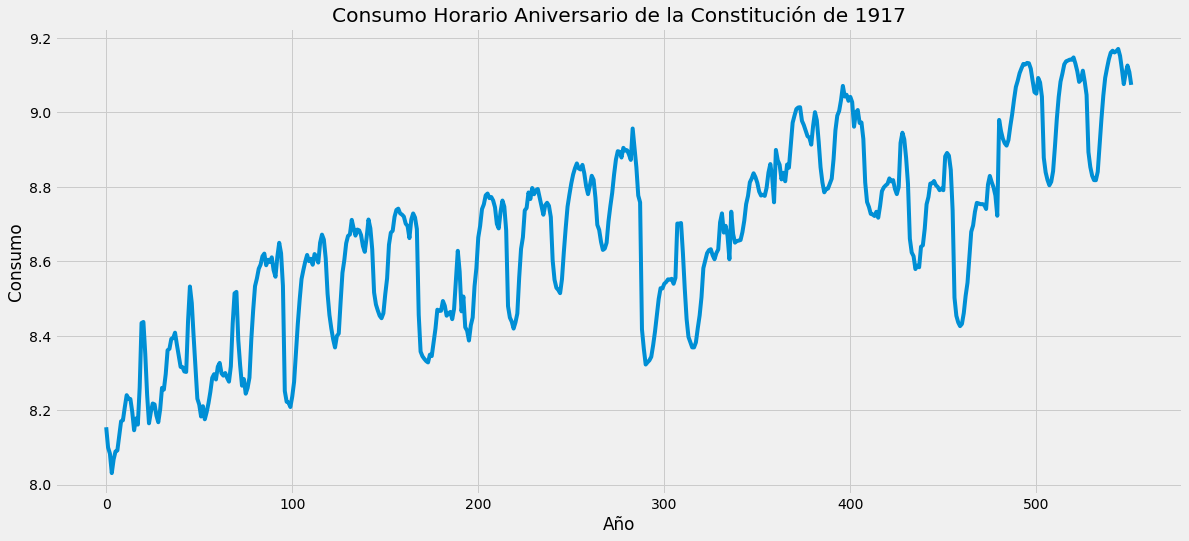

In [65]:
npa_const = np.array(a_const, dtype=float)
ndat = np.round(0.80*len(npa_const))
series_ac = np.log(npa_const)
plt.plot(series_ac)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Aniversario de la Constitución de 1917')
plt.show()

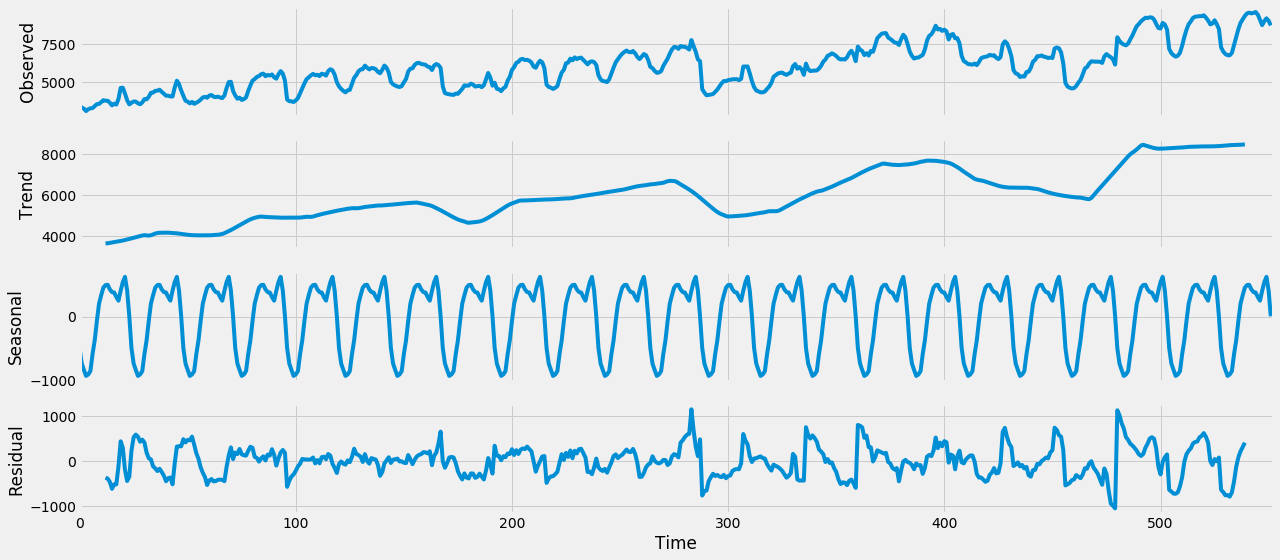

In [66]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npa_const, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [67]:
ac_train =a_const[0:int(ndat)]
ac_test=a_const[int(ndat):len(npa_nuevo)]

In [98]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(ac_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}24 - AIC:{}'.format(param,param_seasonal,results.aic))


ARIMA(0, 0, 0)x(0, 0, 0, 24)24 - AIC:8884.0473661653
ARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:7893.634398529757
ARIMA(0, 0, 0)x(0, 1, 0, 24)24 - AIC:6820.199196471237
ARIMA(0, 0, 0)x(0, 1, 1, 24)24 - AIC:6436.9687282336245
ARIMA(0, 0, 0)x(1, 0, 0, 24)24 - AIC:6834.301746644594
ARIMA(0, 0, 0)x(1, 0, 1, 24)24 - AIC:6820.754325657202
ARIMA(0, 0, 0)x(1, 1, 0, 24)24 - AIC:6454.576068186835
ARIMA(0, 0, 0)x(1, 1, 1, 24)24 - AIC:6401.686857958282
ARIMA(0, 0, 1)x(0, 0, 0, 24)24 - AIC:8279.678980882849
ARIMA(0, 0, 1)x(0, 0, 1, 24)24 - AIC:7364.580112283324
ARIMA(0, 0, 1)x(0, 1, 0, 24)24 - AIC:6402.645380065367
ARIMA(0, 0, 1)x(0, 1, 1, 24)24 - AIC:6033.951771533248
ARIMA(0, 0, 1)x(1, 0, 0, 24)24 - AIC:6433.620036729487
ARIMA(0, 0, 1)x(1, 0, 1, 24)24 - AIC:6409.470133111837
ARIMA(0, 0, 1)x(1, 1, 0, 24)24 - AIC:6069.024184155636
ARIMA(0, 0, 1)x(1, 1, 1, 24)24 - AIC:6002.342949298003
ARIMA(0, 1, 0)x(0, 0, 0, 24)24 - AIC:6185.857265161947
ARIMA(0, 1, 0)x(0, 0, 1, 24)24 - AIC:5759.8549168345135
ARIMA(0, 1

In [68]:
#ARIMA(1, 1, 1)x11, 1, 1, 12)12
mod_ac = sm.tsa.statespace.SARIMAX(np.array(ac_train, dtype=float),
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_ac = mod_ac.fit()
results_ac.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

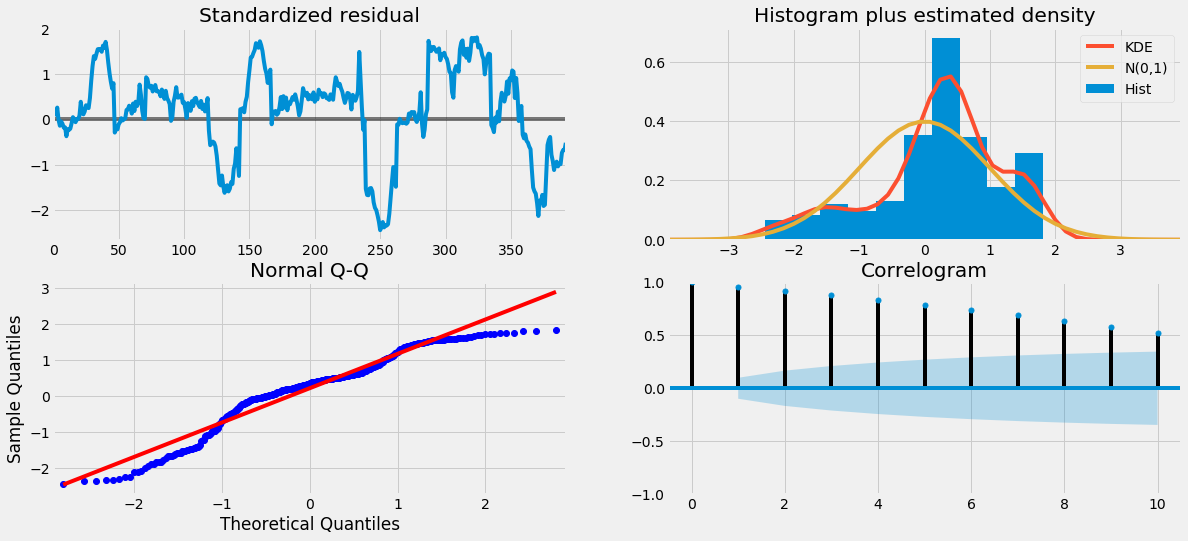

In [70]:
results_ac.plot_diagnostics(figsize=(18, 8))
plt.show()

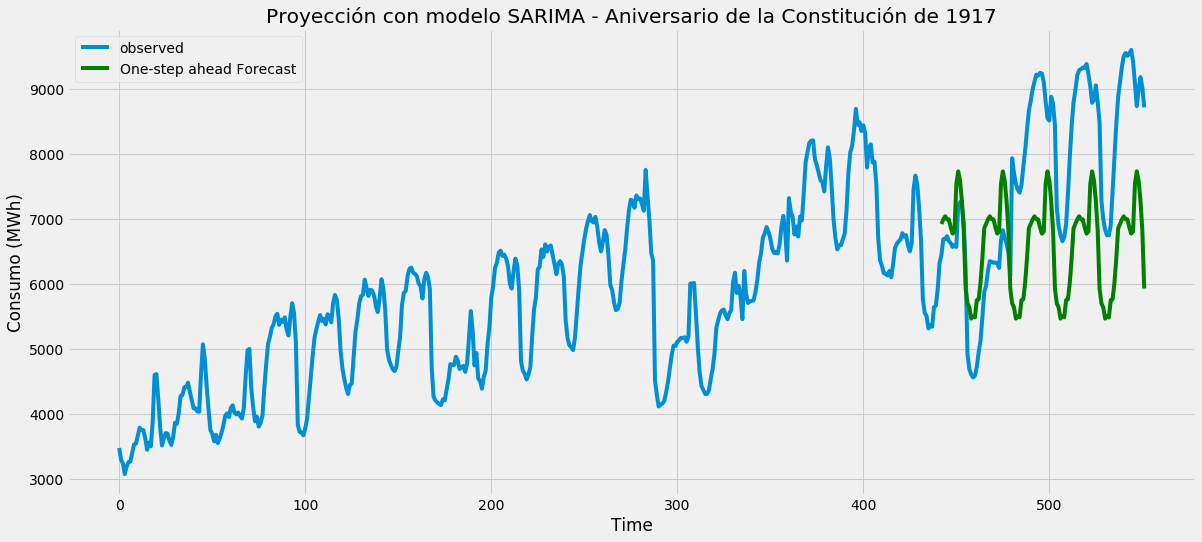

In [71]:
pred_ac_1 = results_ac.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_ac_1.conf_int()
train_ac = np.array(a_const, dtype=float)
ax= plt.plot(train_ac, label='observed')
pred_ac= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_ac['Forecast'] = pred_ac_1.predicted_mean
plt.plot(pred_ac,color='g', label='One-step ahead Forecast')
#plt.fill_between(pred_an.index,pred_ci[:, 1],
#                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Aniversario de la Constitución de 1917')
plt.legend()
plt.show()

In [72]:
errores[names[1]]['SARIMA'] = abs(np.mean((np.asarray(ac_test['MWh'].tolist())-np.asarray(pred_an['Forecast'].tolist()))/np.asarray(pred_an['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Natalicio de Benito Juárez Garcia

In [73]:
nat_bj = data[(data.Day == names[2])].drop(['Day'], axis =1)

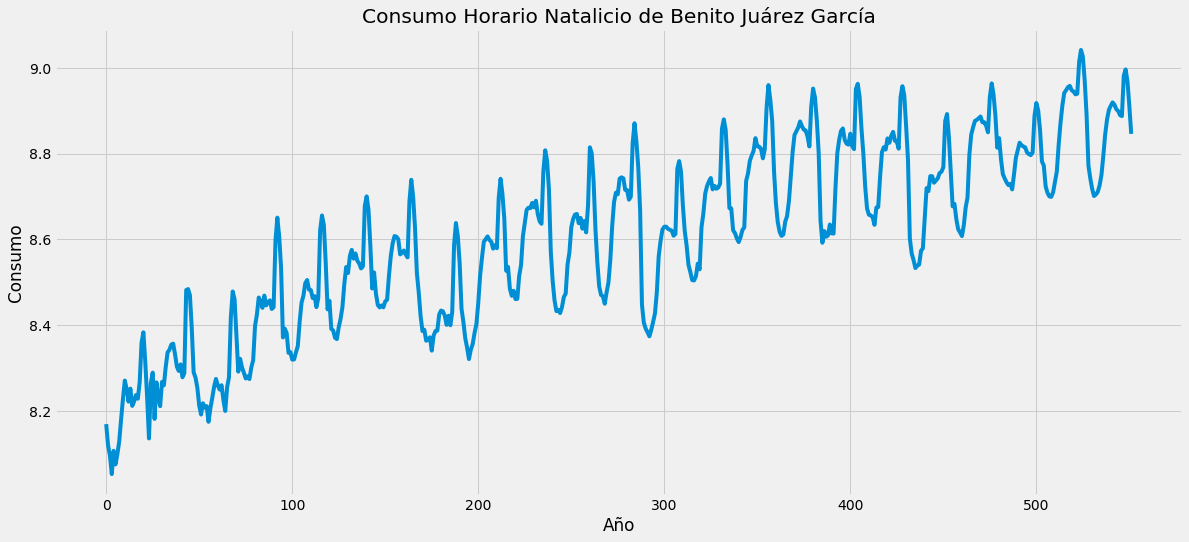

In [74]:
npnat_bj = np.array(nat_bj, dtype=float)
ndat = np.round(0.80*len(npnat_bj))
series_bj = np.log(npnat_bj)
plt.plot(series_bj)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Natalicio de Benito Juárez García')
plt.show()

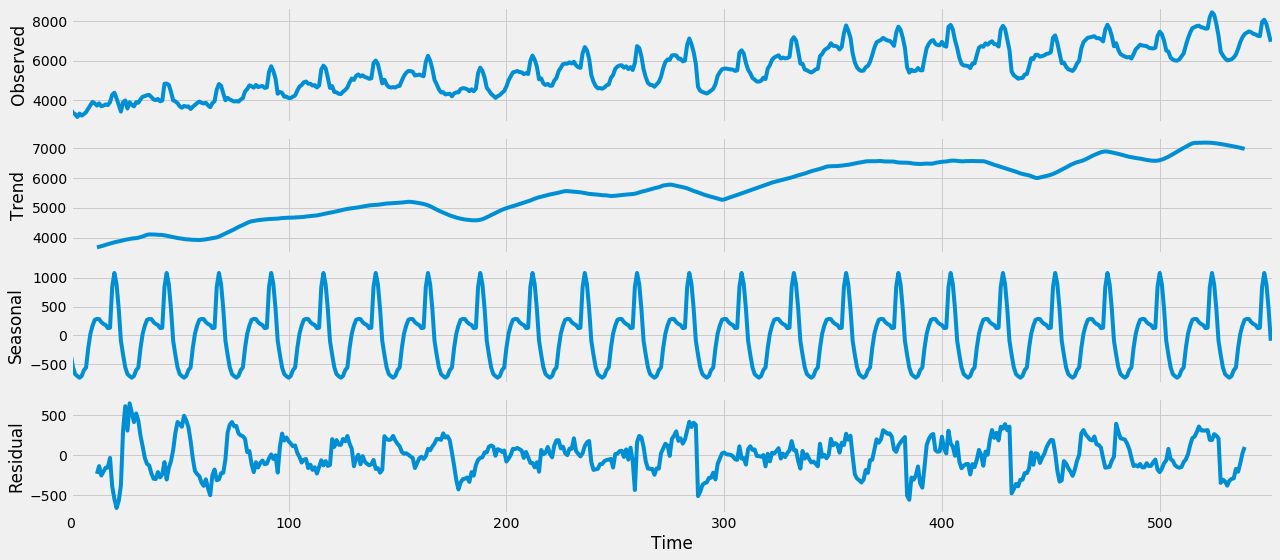

In [75]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npnat_bj, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [76]:
bj_train =nat_bj[0:int(ndat)]
bj_test=nat_bj[int(ndat):len(npnat_bj)]

In [126]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(bj_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8828.22766472921
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7833.822824545041
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6265.275746498535
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:5888.5520678684225
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6245.097797330704
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6180.733487520067
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:5899.395212954083
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:5887.617030790232
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8484.77778501824
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7954.4928457887345
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:5867.116268316042
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5499.466973892074
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:5873.896386478774
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5771.823429112422
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5526.338814148662
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5500.873812949132
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6205.8974103367555
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5649.261125974834
ARIMA(0, 

In [77]:
# ARIMA(0, 1, 1)x(0, 1, 1, 24)
mod_bj = sm.tsa.statespace.SARIMAX(np.array(bj_train, dtype=float),
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_bj = mod_bj.fit()
results_bj.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

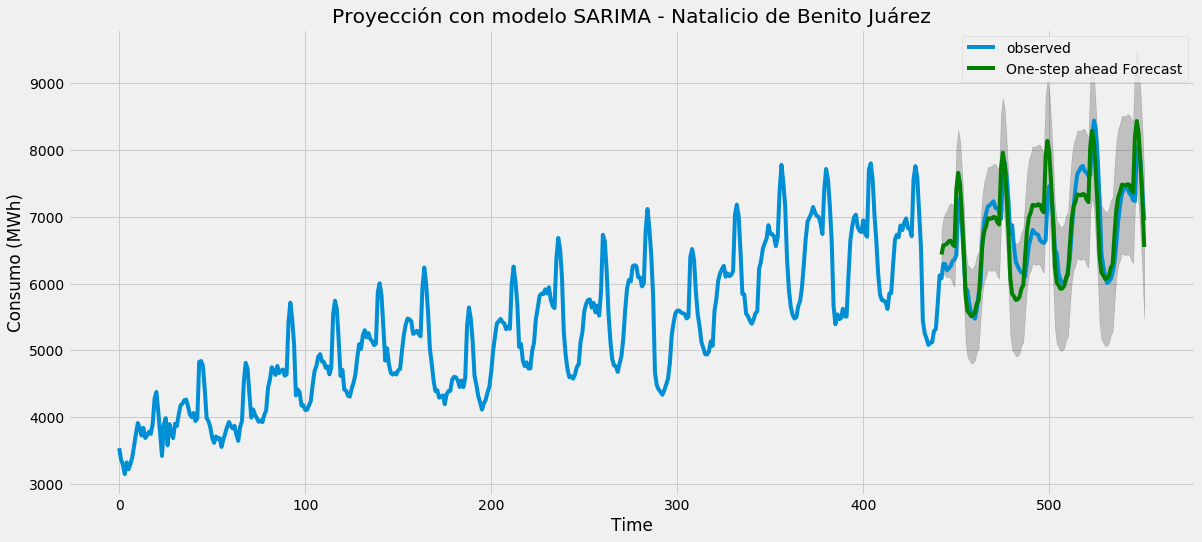

In [78]:
pred_bj_1 = results_bj.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_bj_1.conf_int()
train = np.array(nat_bj, dtype=float)
ax= plt.plot(train, label='observed')
pred_bj= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_bj['Forecast'] = pred_bj_1.predicted_mean
plt.plot(pred_bj,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_bj.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Natalicio de Benito Juárez')
plt.legend()
plt.show()

In [79]:
errores[names[2]]['SARIMA'] = abs(np.mean((np.asarray(bj_test['MWh'].tolist())-np.asarray(pred_bj['Forecast'].tolist()))/np.asarray(pred_an['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Jueves Santo

In [80]:
js = data[(data.Day == names[3])].drop(['Day'], axis =1)

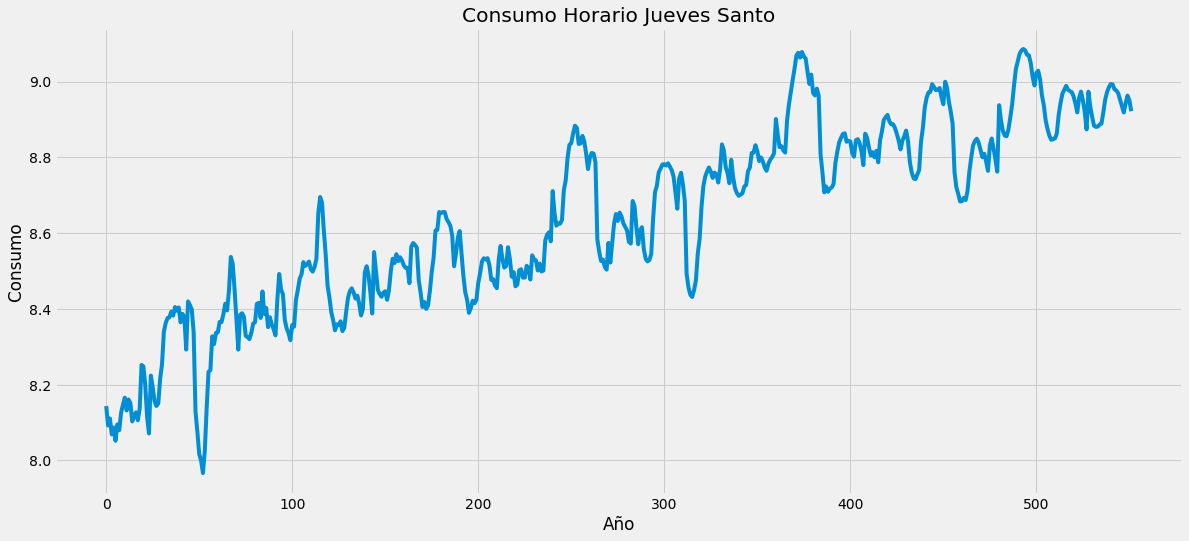

In [81]:
npjs = np.array(js, dtype=float)
ndat = np.round(0.80*len(npjs))
series_js = np.log(npjs)
plt.plot(series_js)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Jueves Santo')
plt.show()

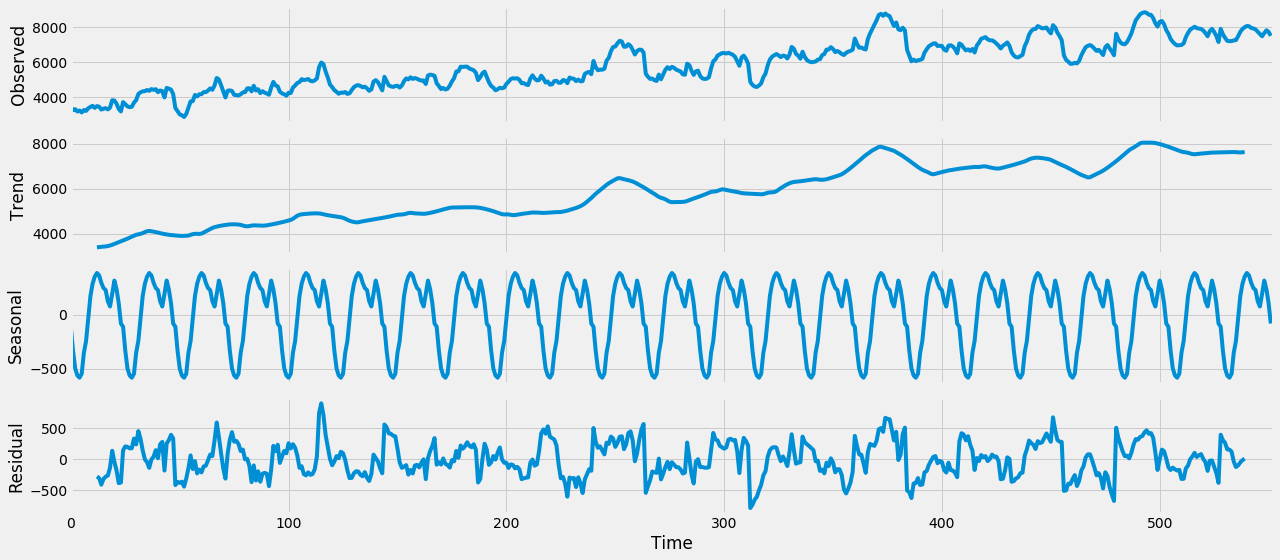

In [82]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npjs, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [83]:
js_train =js[0:int(ndat)]
js_test=js[int(ndat):len(npjs)]

In [152]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(js_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}24 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)24 - AIC:8858.282488516947
ARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:7915.2335299974675
ARIMA(0, 0, 0)x(0, 1, 0, 24)24 - AIC:6797.444064639094
ARIMA(0, 0, 0)x(0, 1, 1, 24)24 - AIC:6319.1299810561195
ARIMA(0, 0, 0)x(1, 0, 0, 24)24 - AIC:6804.252135169007
ARIMA(0, 0, 0)x(1, 0, 1, 24)24 - AIC:6599.087701403541
ARIMA(0, 0, 0)x(1, 1, 0, 24)24 - AIC:6326.356517382669
ARIMA(0, 0, 0)x(1, 1, 1, 24)24 - AIC:6307.493613946082
ARIMA(0, 0, 1)x(0, 0, 0, 24)24 - AIC:8517.042480449702
ARIMA(0, 0, 1)x(0, 0, 1, 24)24 - AIC:7987.920292492201
ARIMA(0, 0, 1)x(0, 1, 0, 24)24 - AIC:6396.94184971212
ARIMA(0, 0, 1)x(0, 1, 1, 24)24 - AIC:5922.692810032919
ARIMA(0, 0, 1)x(1, 0, 0, 24)24 - AIC:6422.767434593426
ARIMA(0, 0, 1)x(1, 0, 1, 24)24 - AIC:6207.550763190049
ARIMA(0, 0, 1)x(1, 1, 0, 24)24 - AIC:5948.567989267949
ARIMA(0, 0, 1)x(1, 1, 1, 24)24 - AIC:5910.099262522651
ARIMA(0, 1, 0)x(0, 0, 0, 24)24 - AIC:6014.968294819896
ARIMA(0, 1, 0)x(0, 0, 1, 24)24 - AIC:5697.59100251979
ARIMA(0, 1

In [84]:
#ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:5657.04596474992
mod_js = sm.tsa.statespace.SARIMAX(np.array(js_train, dtype=float),
                                order=(0, 0, 1),
                                seasonal_order=(2, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_js = mod_js.fit()
results_js.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

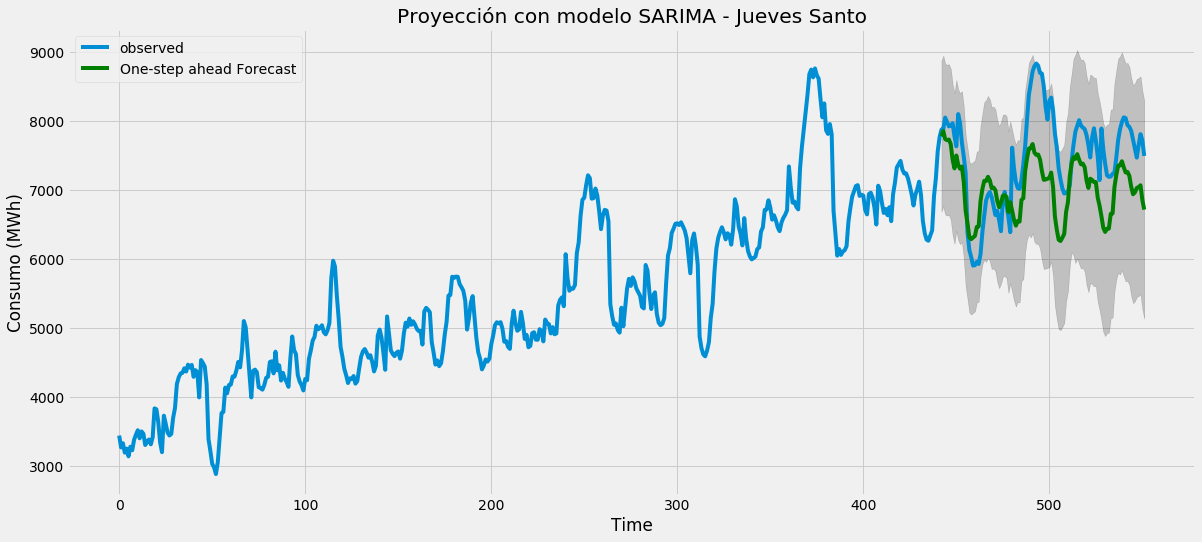

In [85]:
pred_js_1 = results_js.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_js_1.conf_int()
train = np.array(js, dtype=float)
ax= plt.plot(train, label='observed')
pred_js= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_js['Forecast'] = pred_js_1.predicted_mean
plt.plot(pred_js,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_js.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Jueves Santo')
plt.legend()
plt.show()

In [86]:
errores[names[3]]['SARIMA'] = abs(np.mean((np.asarray(js_test['MWh'].tolist())-np.asarray(pred_js['Forecast'].tolist()))/np.asarray(pred_js['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Viernes Santo

In [87]:
vs = data[(data.Day == names[4])].drop(['Day'], axis =1)

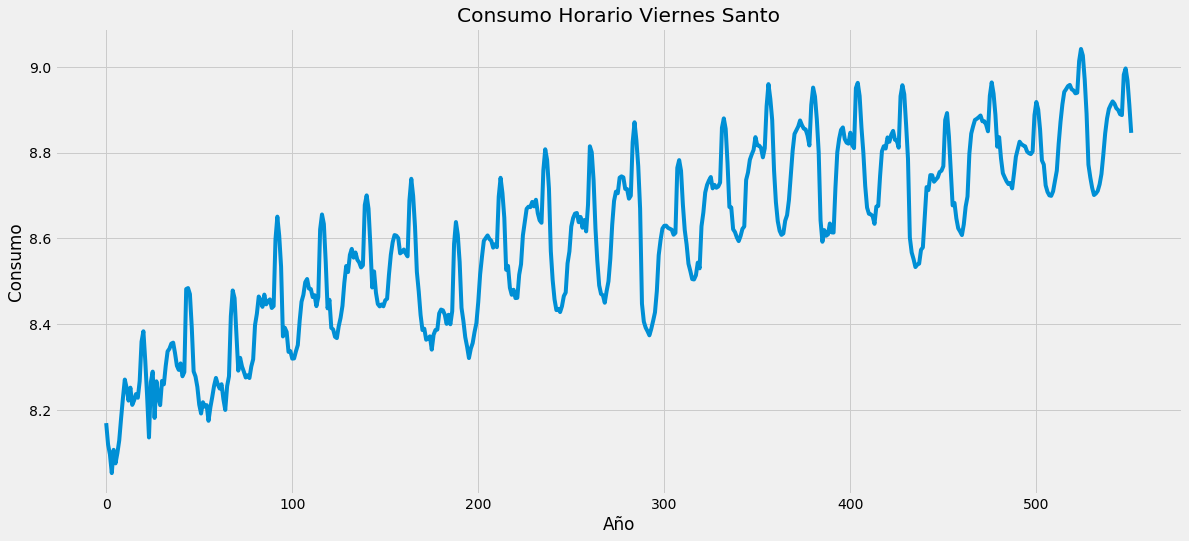

In [88]:
npvs = np.array(vs, dtype=float)
ndat = np.round(0.80*len(npvs))
series_vs = np.log(npvs)
plt.plot(series_bj)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Viernes Santo')
plt.show()

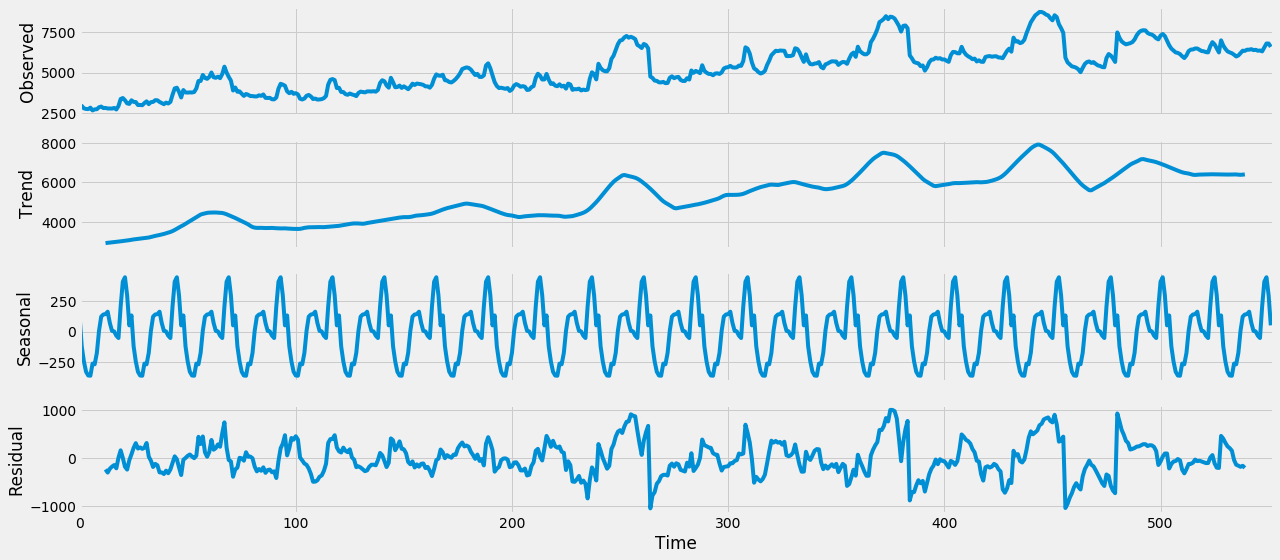

In [89]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npvs, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [90]:
vs_train =vs[0:int(ndat)]
vs_test=vs[int(ndat):len(npvs)]

In [195]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(vs_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8777.112369435106
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7884.5488219358185
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:7061.064361036012
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:6551.667864813084
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:7077.409880301563
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6938.144606367048
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:6578.142281175803
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:6542.430267462608
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8437.203234408913
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7418.399468334037
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:6629.261750764888
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:6135.492975611032
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:6661.462922230245
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:6428.715258506183
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:6182.634643172883
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:6126.196825883035
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6079.41708657079
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5765.599047692699
ARIMA(0, 1

In [91]:
#ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:5720.963626253484
vs_mod = sm.tsa.statespace.SARIMAX(np.array(vs_train, dtype=float),
                                order=(1, 0, 0),
                                seasonal_order=(2, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_vs = vs_mod.fit()
results_vs.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

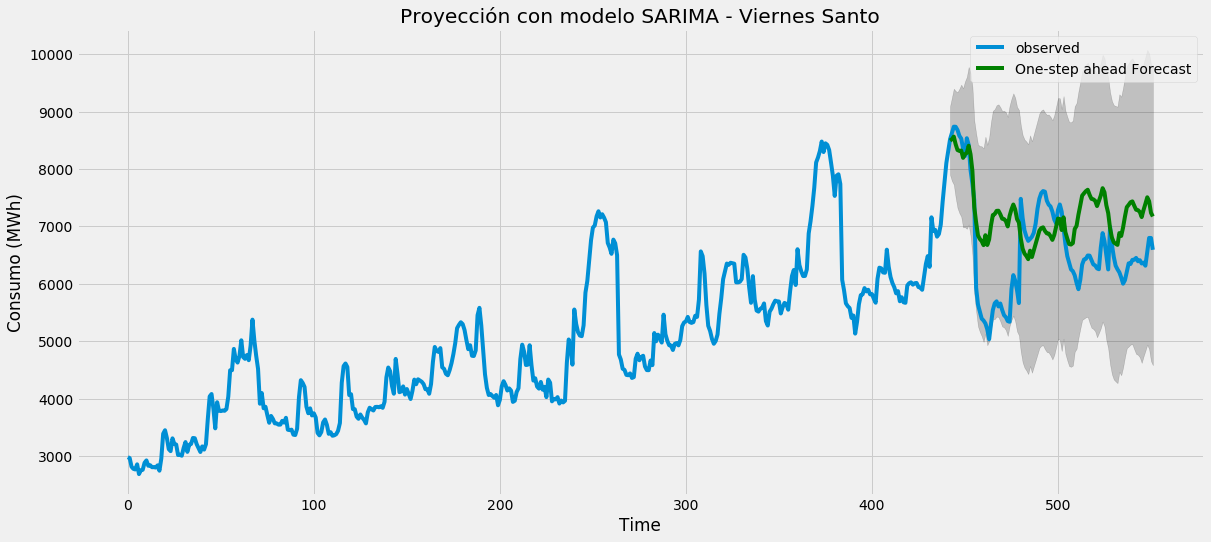

In [92]:
pred_vs_1 = results_vs.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_vs_1.conf_int()
train = np.array(vs, dtype=float)
ax= plt.plot(train, label='observed')
pred_vs= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_vs['Forecast'] = pred_vs_1.predicted_mean
plt.plot(pred_vs,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_vs.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Viernes Santo')
plt.legend()
plt.show()

In [93]:
errores[names[4]]['SARIMA'] = abs(np.mean((np.asarray(vs_test['MWh'].tolist())-np.asarray(pred_vs['Forecast'].tolist()))/np.asarray(pred_vs['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Día del Trabajo

In [94]:
dt = data[(data.Day == names[5])].drop(['Day'], axis =1)

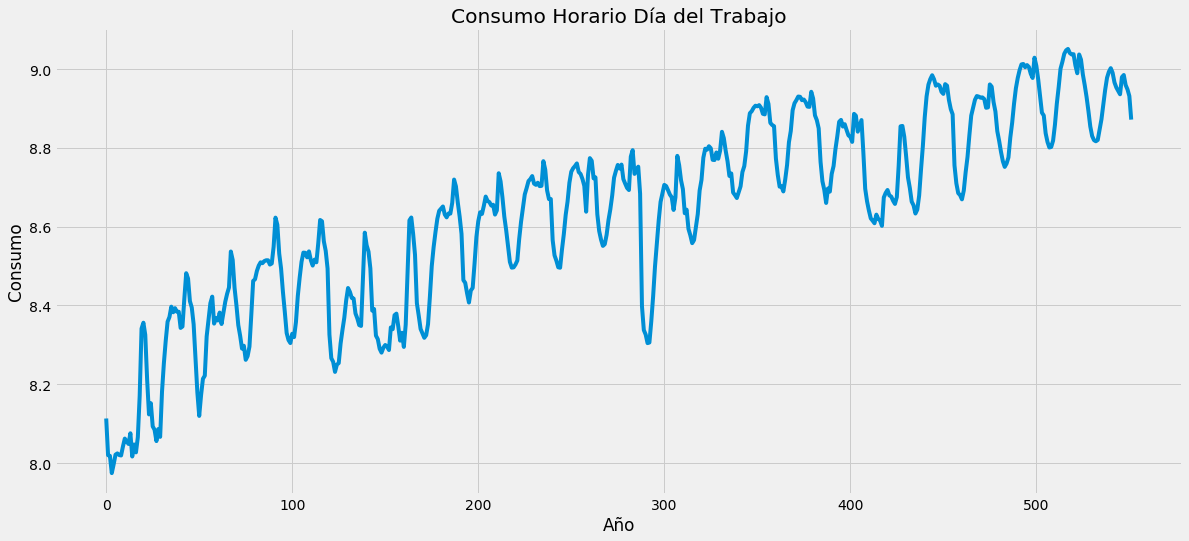

In [95]:
npdt = np.array(dt, dtype=float)
ndat = np.round(0.80*len(npdt))
series_dt = np.log(npdt)
plt.plot(series_dt)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Día del Trabajo')
plt.show()

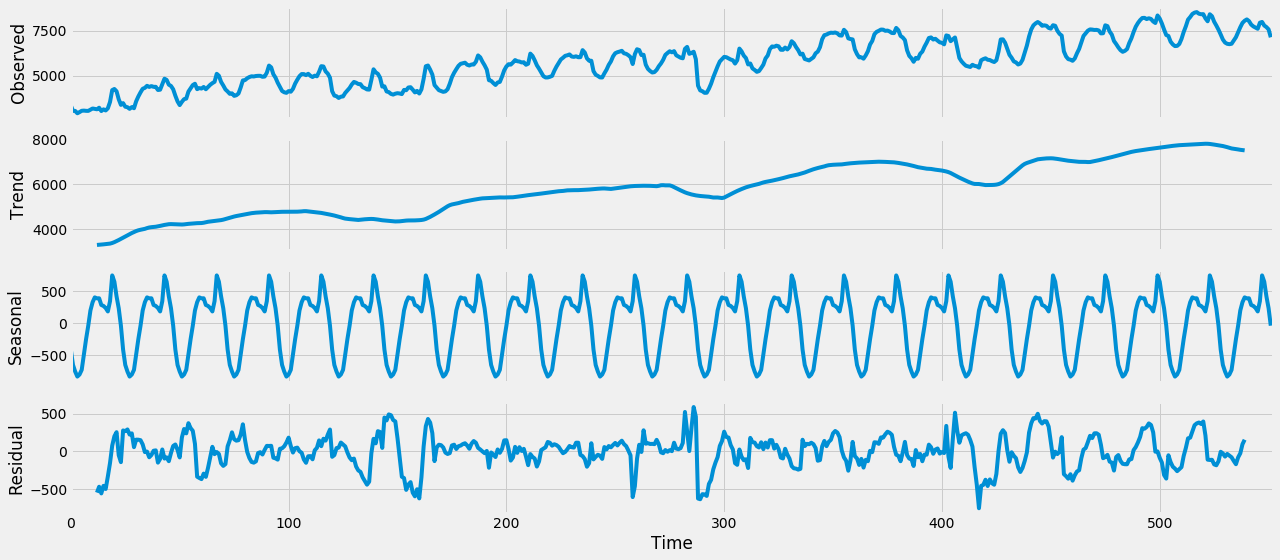

In [96]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npdt, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [97]:
dt_train =dt[0:int(ndat)]
dt_test=dt[int(ndat):len(npdt)]

In [262]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(dt_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8845.091254800034
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7852.288972924018
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6466.611949209619
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:6060.064574976798
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6464.0172406237725
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6449.175215379602
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:6075.120253407684
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:6047.404107998077
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8504.241184898692
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7300.704177358924
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:6043.699053157695
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5668.388492350218
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:6060.30977860486
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:6034.628687891805
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5696.974846026615
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5654.615563746731
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6031.587072201797
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5599.098474104457
ARIMA(0, 1

In [98]:
#ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:5485.8256672811285
mod_dt = sm.tsa.statespace.SARIMAX(np.array(dt_train, dtype=float),
                                order=(0, 1, 0),
                                seasonal_order=(2, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_dt = mod_dt.fit()
results_dt.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

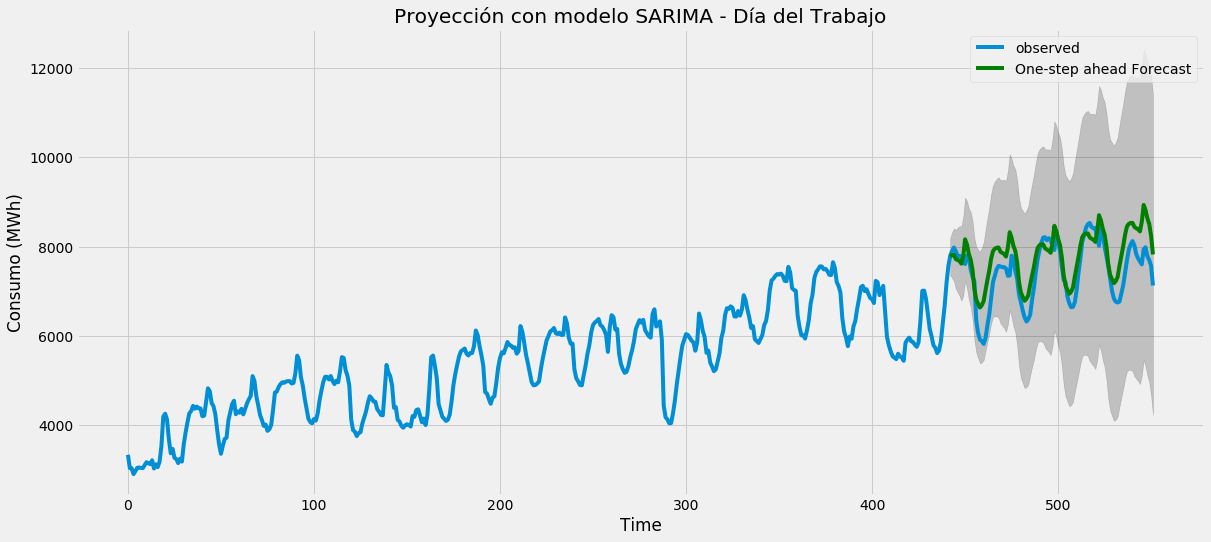

In [99]:
pred_dt_1 = results_dt.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_dt_1.conf_int()
train = np.array(dt, dtype=float)
ax= plt.plot(train, label='observed')
pred_dt= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_dt['Forecast'] = pred_dt_1.predicted_mean
plt.plot(pred_dt,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_dt.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Día del Trabajo')
plt.legend()
plt.show()

In [100]:
errores[names[5]]['SARIMA'] = abs(np.mean((np.asarray(dt_test['MWh'].tolist())-np.asarray(pred_dt['Forecast'].tolist()))/np.asarray(pred_dt['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Día de la madre

In [101]:
dm = data[(data.Day == names[6])].drop(['Day'], axis =1)

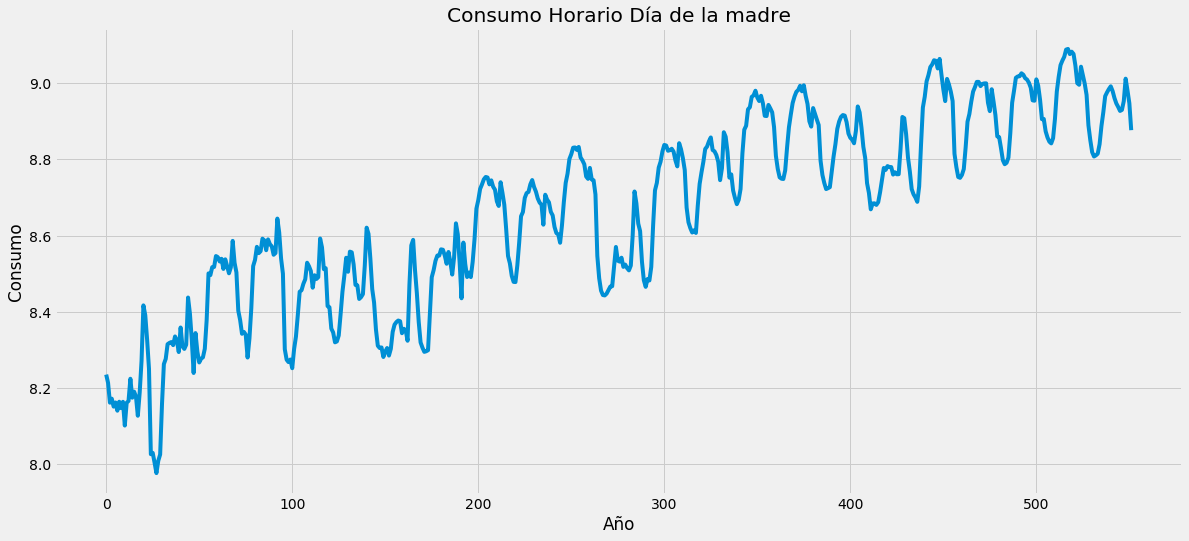

In [102]:
npdm = np.array(dm, dtype=float)
ndat = np.round(0.80*len(npdm))
series_dm = np.log(npdm)
plt.plot(series_dm)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Día de la madre')
plt.show()

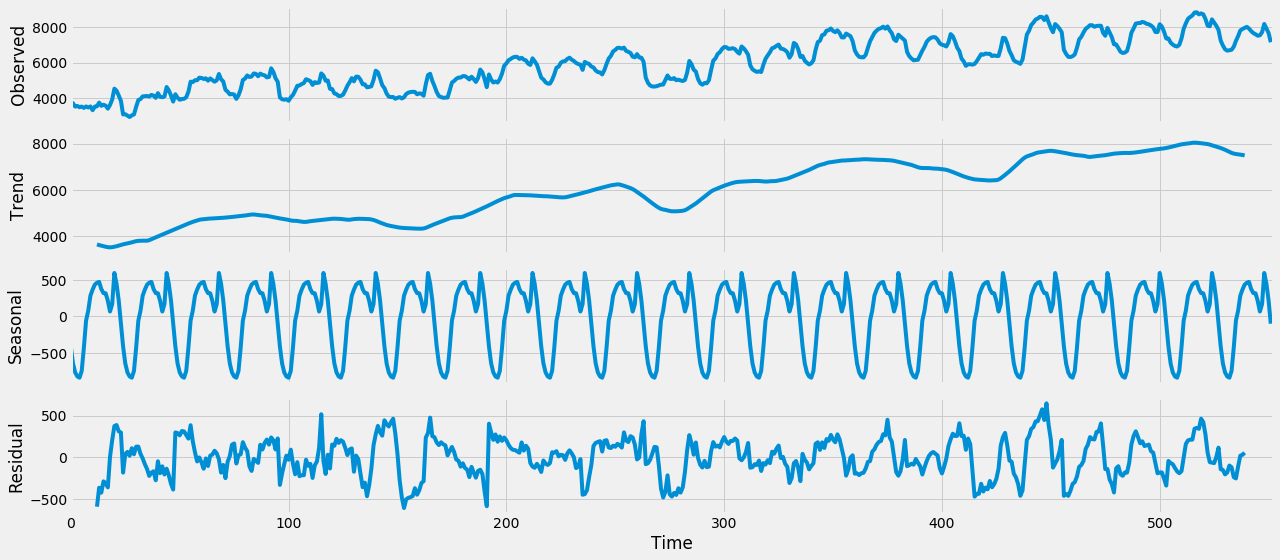

In [103]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npdm, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [104]:
dm_train =dm[0:int(ndat)]
dm_test=dm[int(ndat):len(npdm)]

In [267]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(dm_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8874.267694200144
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7939.69950444116
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6643.796183366388
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:6257.85296107493
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6649.358566702567
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6609.45789396781
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:6270.054275537539
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:6234.99696462047
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8532.223648542853
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:8001.244196864864
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:6225.476317704535
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5841.87707893574
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:6251.941460212078
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:6233.3914112135535
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5865.001633019647
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5828.842365218972
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6062.690795373477
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5641.357451458805
ARIMA(0, 1, 0)

In [105]:
mod_dm = sm.tsa.statespace.SARIMAX(np.array(dm_train, dtype=float),
                                order=(1, 0, 0),
                                seasonal_order=(2, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_dm = mod_dm.fit()
results_dm.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

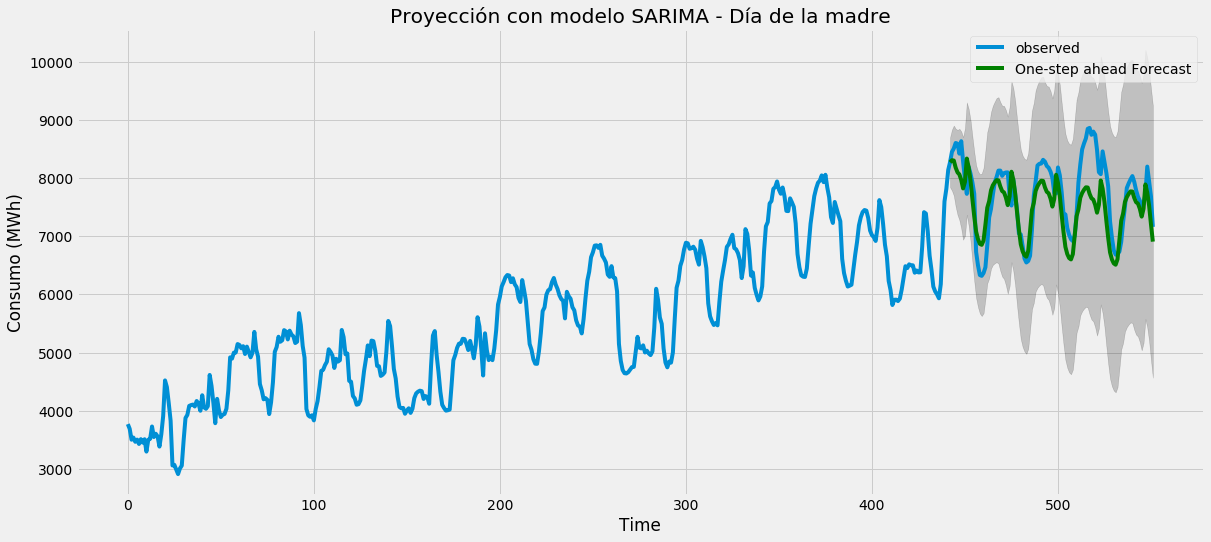

In [106]:
pred_dm_1 = results_dm.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_dm_1.conf_int()
train = np.array(dm, dtype=float)
ax= plt.plot(train, label='observed')
pred_dm= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_dm['Forecast'] = pred_dm_1.predicted_mean
plt.plot(pred_dm,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_dm.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Día de la madre')
plt.legend()
plt.show()

In [107]:
errores[names[6]]['SARIMA'] = abs(np.mean((np.asarray(dm_test['MWh'].tolist())-np.asarray(pred_dm['Forecast'].tolist()))/np.asarray(pred_dm['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Día de la Independencia

In [108]:
d_ind = data[(data.Day == names[7])].drop(['Day'], axis =1)

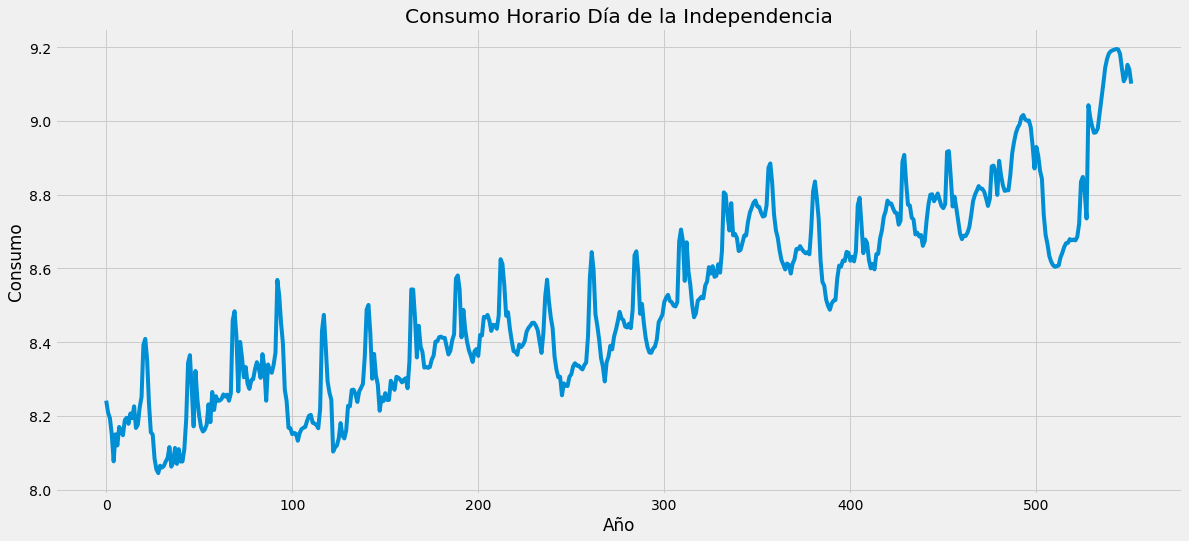

In [109]:
npd_ind= np.array(d_ind, dtype=float)
ndat = np.round(0.80*len(npd_ind))
series_dind = np.log(npd_ind)
plt.plot(series_dind)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Día de la Independencia')
plt.show()

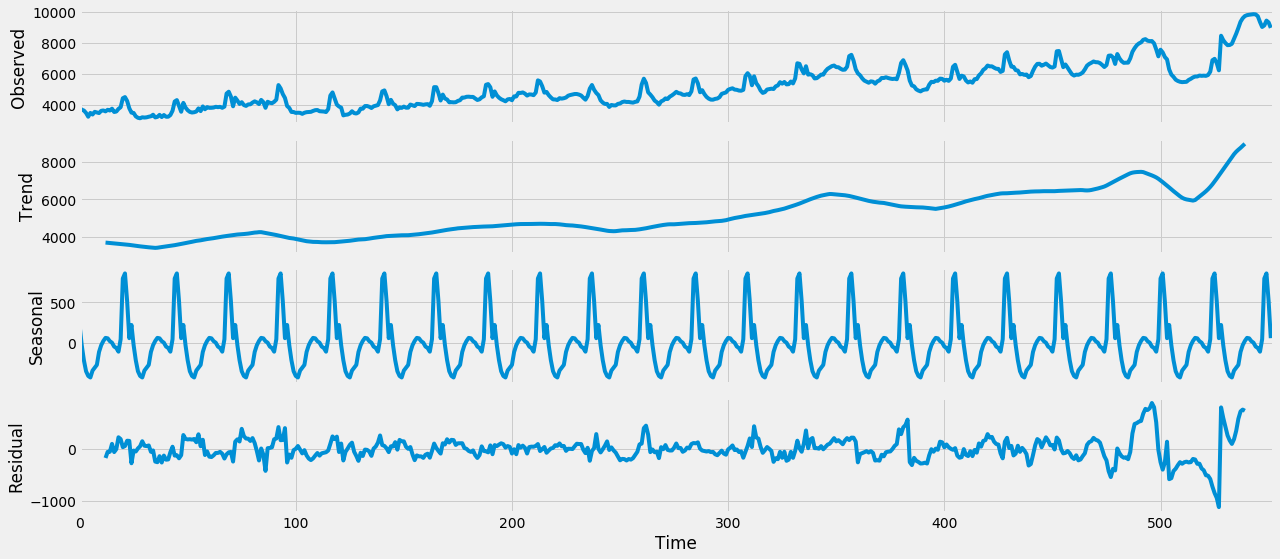

In [110]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npd_ind, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [111]:
di_train =d_ind[0:int(ndat)]
di_test=d_ind[int(ndat):len(npd_ind)]

In [275]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(di_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8725.90820534573
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7991.77868799823
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6297.5303217431765
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:5948.415201552996
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6273.017519443492
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6160.976199477526
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:5964.571785149465
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:5937.559740856213
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8388.557875548748
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7221.466161081616
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:5929.041854222748
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5594.696995955383
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:5932.229748449081
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5921.509095146052
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5626.061921376084
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5578.073230814175
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6100.242536787328
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5590.382513305793
ARIMA(0, 1,

In [112]:

mod_di = sm.tsa.statespace.SARIMAX(np.array(di_train, dtype=float),
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_di = mod_di.fit()
results_di.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

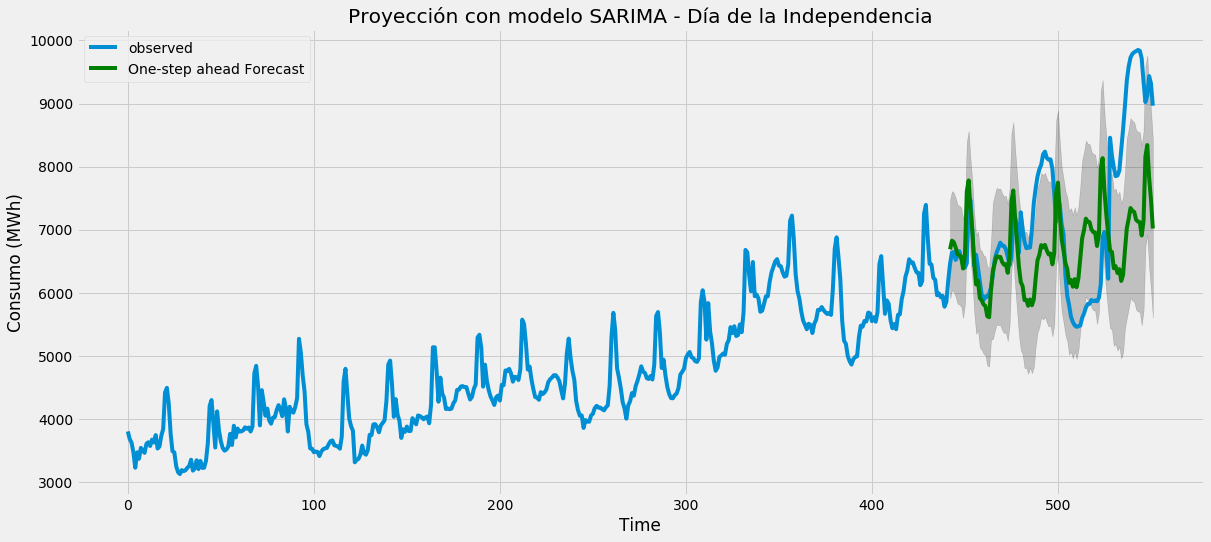

In [113]:
pred_di_1 = results_di.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_di_1.conf_int()
train = np.array(d_ind, dtype=float)
ax= plt.plot(train, label='observed')
pred_di= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_di['Forecast'] = pred_di_1.predicted_mean
plt.plot(pred_di,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_di.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Día de la Independencia')
plt.legend()
plt.show()

In [114]:
errores[names[7]]['SARIMA'] = abs(np.mean((np.asarray(di_test['MWh'].tolist())-np.asarray(pred_di['Forecast'].tolist()))/np.asarray(pred_di['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Zapopan

In [115]:
vz = data[(data.Day == names[8])].drop(['Day'], axis =1)

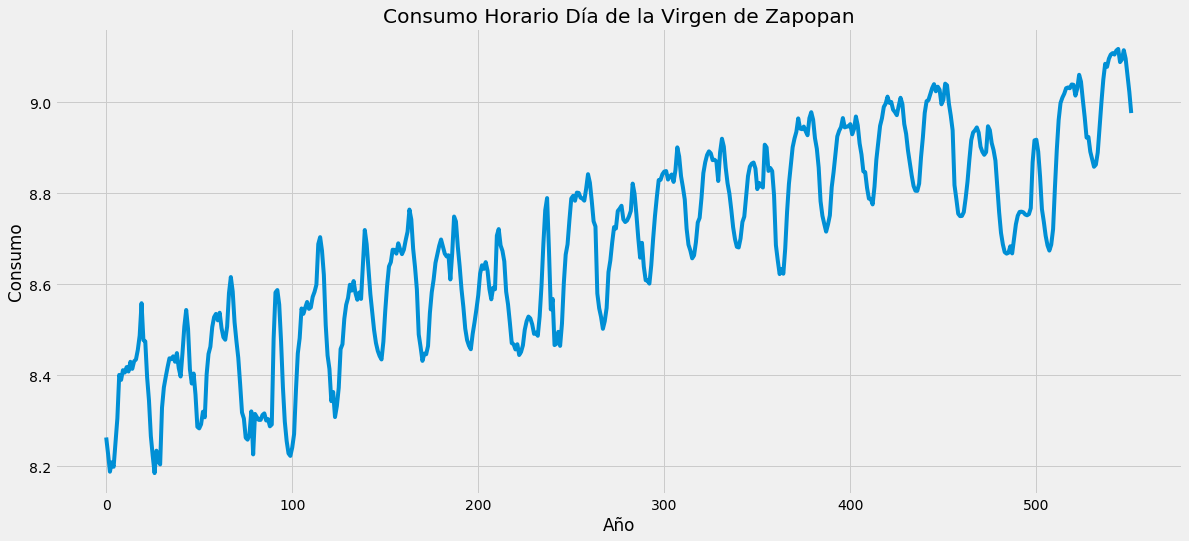

In [116]:
npvz = np.array(vz, dtype=float)
ndat = np.round(0.80*len(npvz))
series_vz = np.log(npvz)
plt.plot(series_vz)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Día de la Virgen de Zapopan')
plt.show()

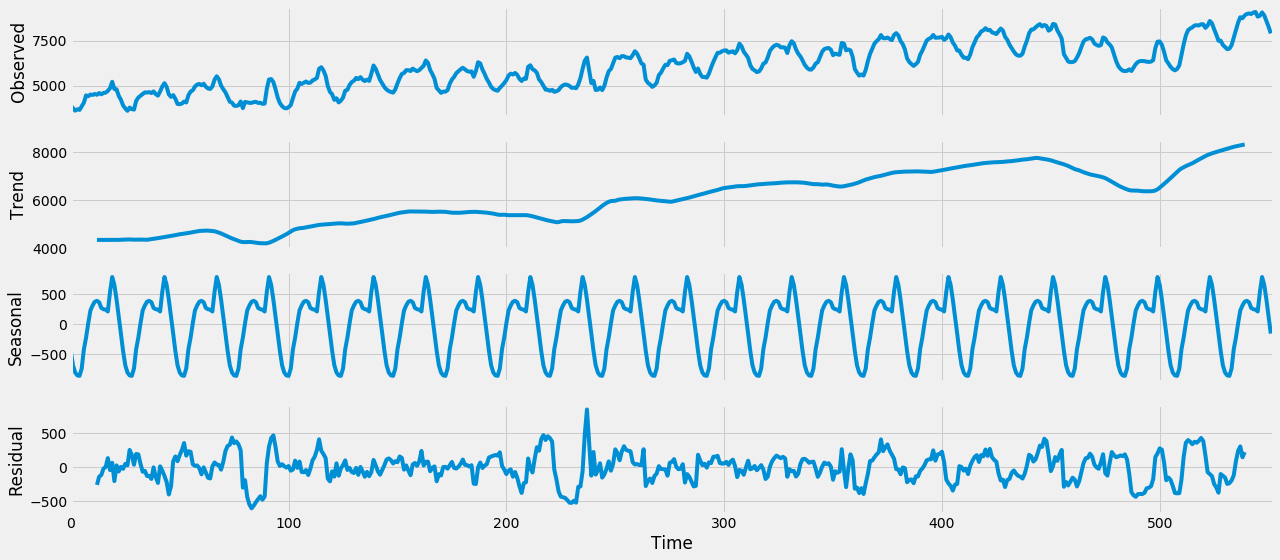

In [117]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npvz, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [118]:
vz_train =vz[0:int(ndat)]
vz_test= vz[int(ndat):len(npvz)]

In [432]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(vz_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))


ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8905.669070247037
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7974.061607595836
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6350.76159609439
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:5987.363330955603
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6309.923197108628
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6172.357543708716
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:5990.601123824301
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:5922.68714277377
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8564.536382650478
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:8030.852344864277
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:5964.396406531282
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5599.443771883437
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:5953.755817856118
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5724.135432604877
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5609.385841886679
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5564.704570403967
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6021.493450035077
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5590.188909464503
ARIMA(0, 1, 

In [119]:
#ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:5407.545395108378
mod_vz = sm.tsa.statespace.SARIMAX(np.array(vz_train, dtype=float),
                                order=(0, 0, 1),
                                seasonal_order=(2, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_vz = mod_vz.fit()
results_vz.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

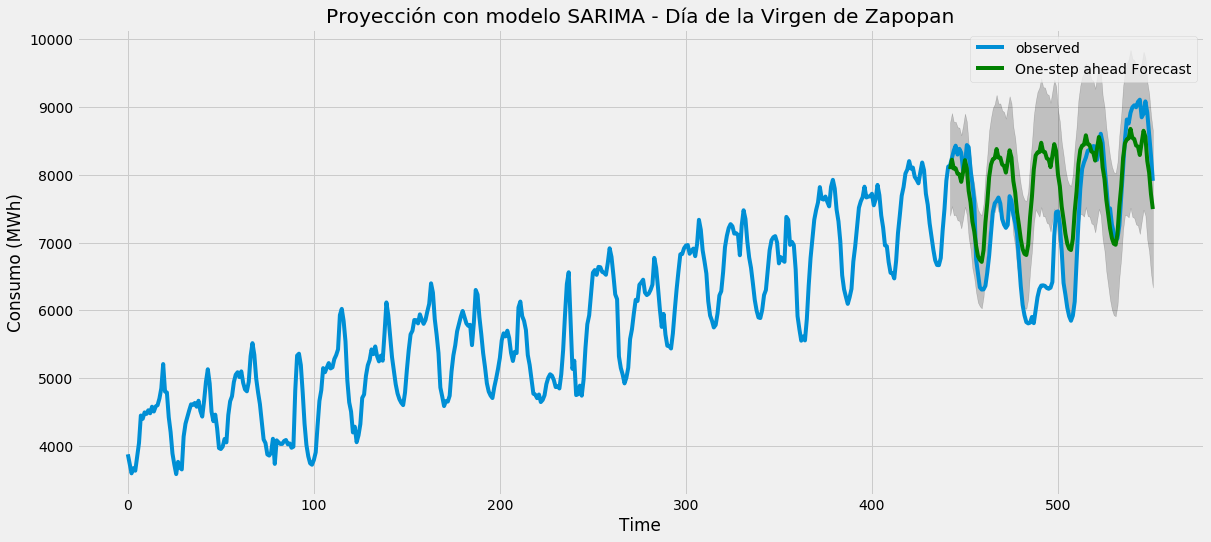

In [120]:
pred_vz_1 = results_vz.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_vz_1.conf_int()
train = np.array(vz, dtype=float)
ax= plt.plot(train, label='observed')
pred_vz= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_vz['Forecast'] = pred_vz_1.predicted_mean
plt.plot(pred_vz,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_vz.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Día de la Virgen de Zapopan')
plt.legend()
plt.show()

In [121]:
errores[names[8]]['SARIMA'] = abs(np.mean((np.asarray(vz_test['MWh'].tolist())-np.asarray(pred_vz['Forecast'].tolist()))/np.asarray(pred_vz['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Día de los muertos

In [122]:
dmuer = data[(data.Day == names[9])].drop(['Day'], axis =1)

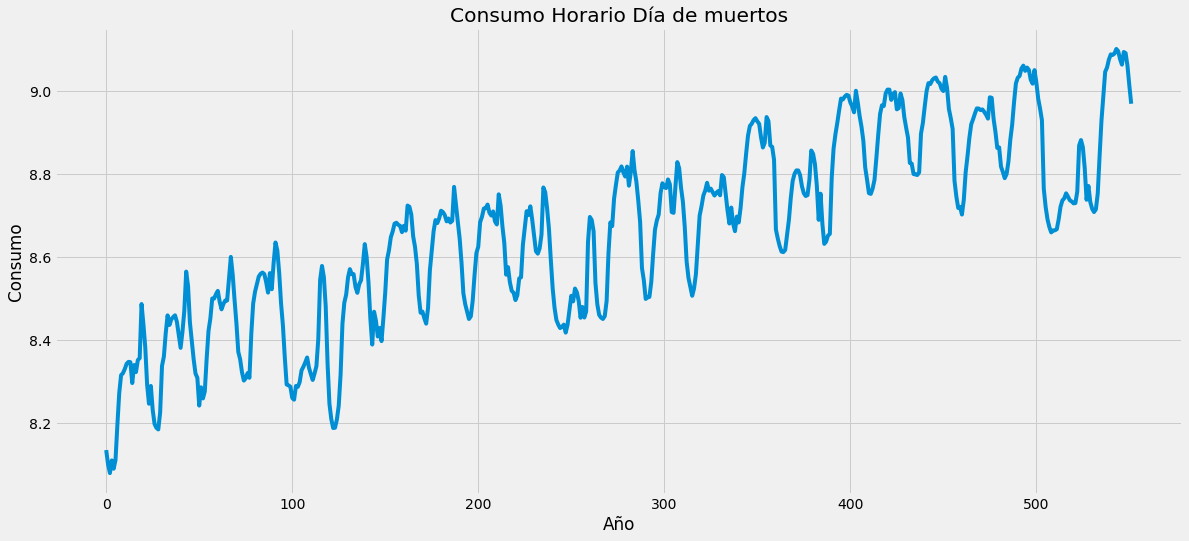

In [123]:
npdmuer = np.array(dmuer, dtype=float)
ndat = np.round(0.80*len(npdmuer))
series_dmuer = np.log(npdmuer)
plt.plot(series_dmuer)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Día de muertos')
plt.show()

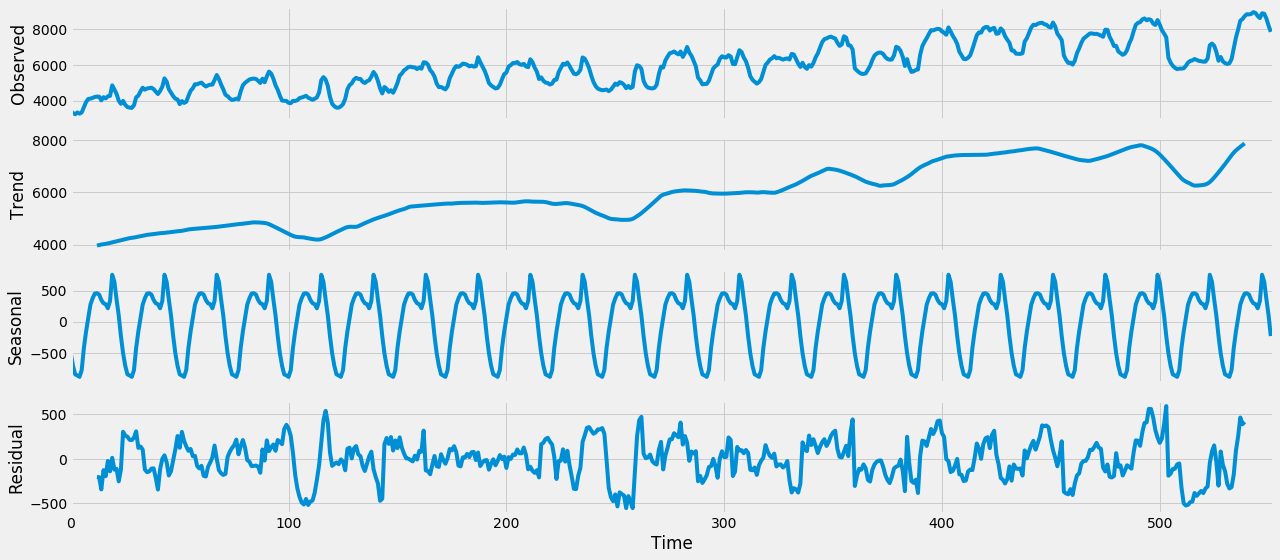

In [124]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npdmuer, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [125]:
dm_train =dmuer[0:int(ndat)]
dm_test=dmuer[int(ndat):len(npdmuer)]

In [290]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(dm_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8880.197817402068
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:8134.331865321992
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6563.731288456315
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:6158.531437611354
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6547.047646399763
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6450.826838575078
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:6167.3185371506115
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:6154.162714783928
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8538.651350800741
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7344.720213787161
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:6148.72374174285
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5750.143987516373
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:6155.277912933513
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5956.51228487749
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5772.449825035779
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5744.928018990613
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6058.51385152293
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5641.604319387818
ARIMA(0, 1, 

In [126]:
#ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:5539.905354448363
mod_dmu = sm.tsa.statespace.SARIMAX(np.array(dmuer, dtype=float),
                                order=(1, 0, 0),
                                seasonal_order=(1, 1, 0, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_dmu = mod_dmu.fit()
results_dmu.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

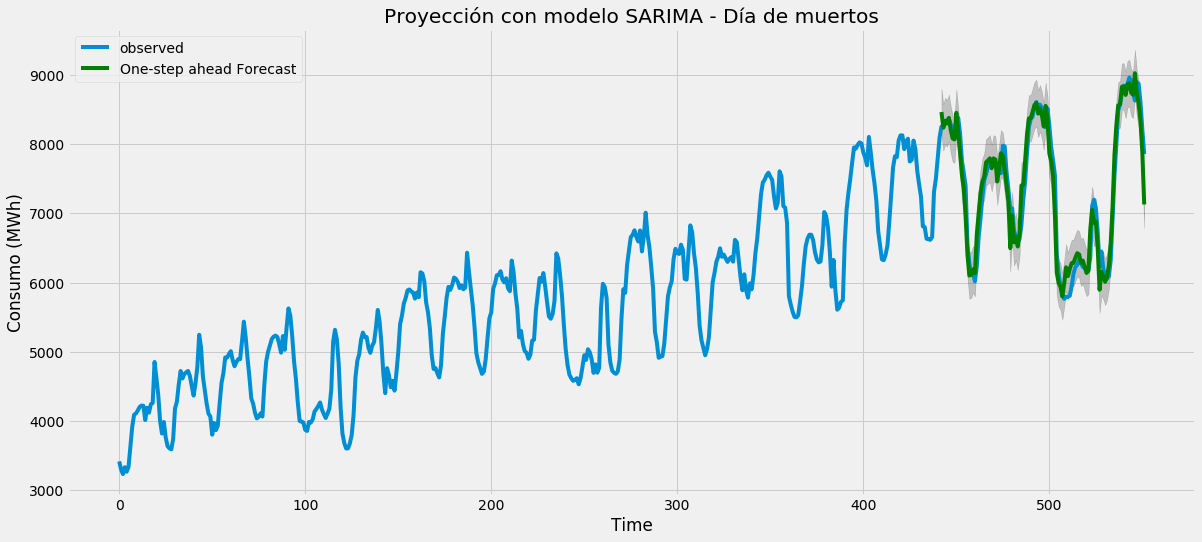

In [127]:
pred_dmu_1 = results_dmu.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_dmu_1.conf_int()
train = np.array(dmuer, dtype=float)
ax= plt.plot(train, label='observed')
pred_dmu= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_dmu['Forecast'] = pred_dmu_1.predicted_mean
plt.plot(pred_dmu,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_vz.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Día de muertos')
plt.legend()
plt.show()

In [128]:
errores[names[9]]['SARIMA'] = abs(np.mean((np.asarray(dm_test['MWh'].tolist())-np.asarray(pred_dm['Forecast'].tolist()))/np.asarray(pred_dm['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Día de la Revolución

In [129]:
d_rev = data[(data.Day == names[10])].drop(['Day'], axis =1)

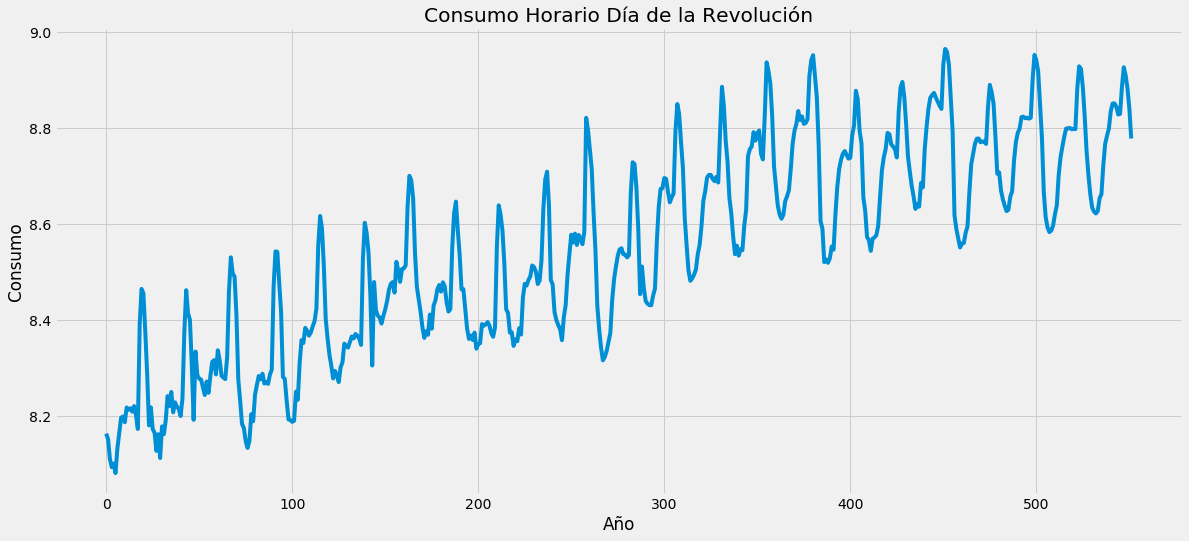

In [130]:
npd_rev = np.array(d_rev, dtype=float)
ndat = np.round(0.80*len(npd_rev))
series_drev = np.log(npd_rev)
plt.plot(series_drev)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Día de la Revolución')
plt.show()

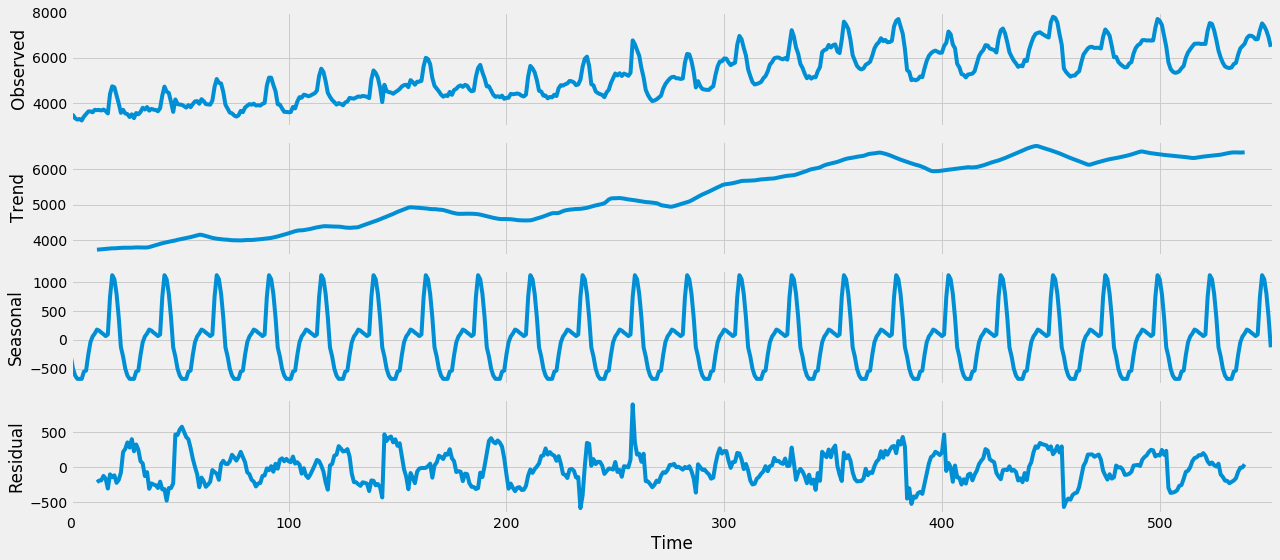

In [131]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npd_rev, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [132]:
dr_train =d_rev[0:int(ndat)]
dr_test=d_rev[int(ndat):len(npd_rev)]

In [298]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(dr_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8782.449252923085
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:8051.007902356639
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6150.728940417304
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:5808.395654582361
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6111.473774988664
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6023.856820262555
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:5820.693494773612
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:5781.114257062476
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8443.816050306747
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7306.702755960935
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:5864.5766890316045
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5509.352071023709
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:5858.165142624859
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5701.715603390378
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5526.013501973813
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5494.260469688518
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6174.8768194009135
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5708.150057671806
ARIMA(0,

In [133]:
#ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:5539.905354448363
mod_dr = sm.tsa.statespace.SARIMAX(np.array(dr_train, dtype=float),
                                order=(1, 0, 1),
                                seasonal_order=(2, 1, 0, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_dr = mod_dr.fit()
results_dr.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

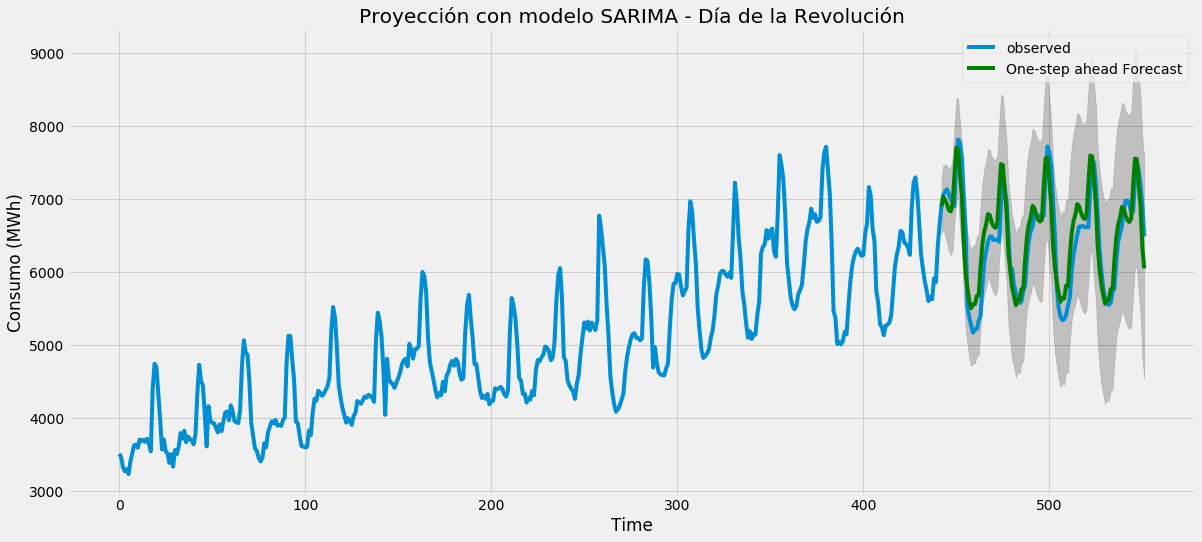

In [134]:
pred_dr_1 = results_dr.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_dr_1.conf_int()
train = np.array(d_rev, dtype=float)
ax= plt.plot(train, label='observed')
pred_dr= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_dr['Forecast'] = pred_dr_1.predicted_mean
plt.plot(pred_dr,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_dr.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Día de la Revolución')
plt.legend()
plt.show()

In [135]:
errores[names[10]]['SARIMA'] = abs(np.mean((np.asarray(dr_test['MWh'].tolist())-np.asarray(pred_dr['Forecast'].tolist()))/np.asarray(pred_dr['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Guadalupe

In [136]:
vg = data[(data.Day == names[11])].drop(['Day'], axis =1)

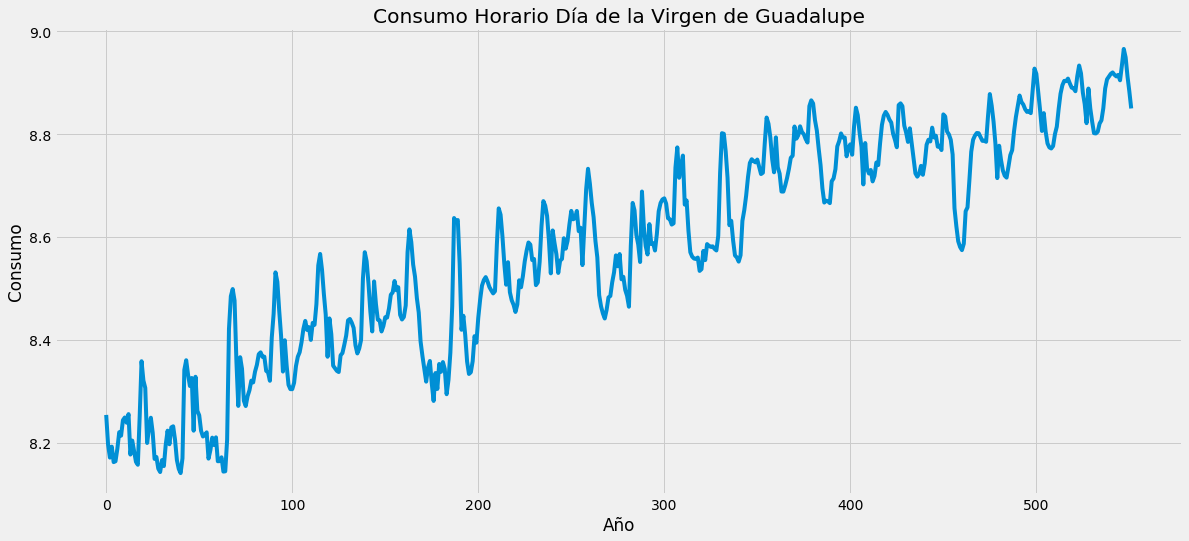

In [137]:
npvg = np.array(vg, dtype=float)
ndat = np.round(0.80*len(npvg))
series_vg = np.log(npvg)
plt.plot(series_vg)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Día de la Virgen de Guadalupe')
plt.show()

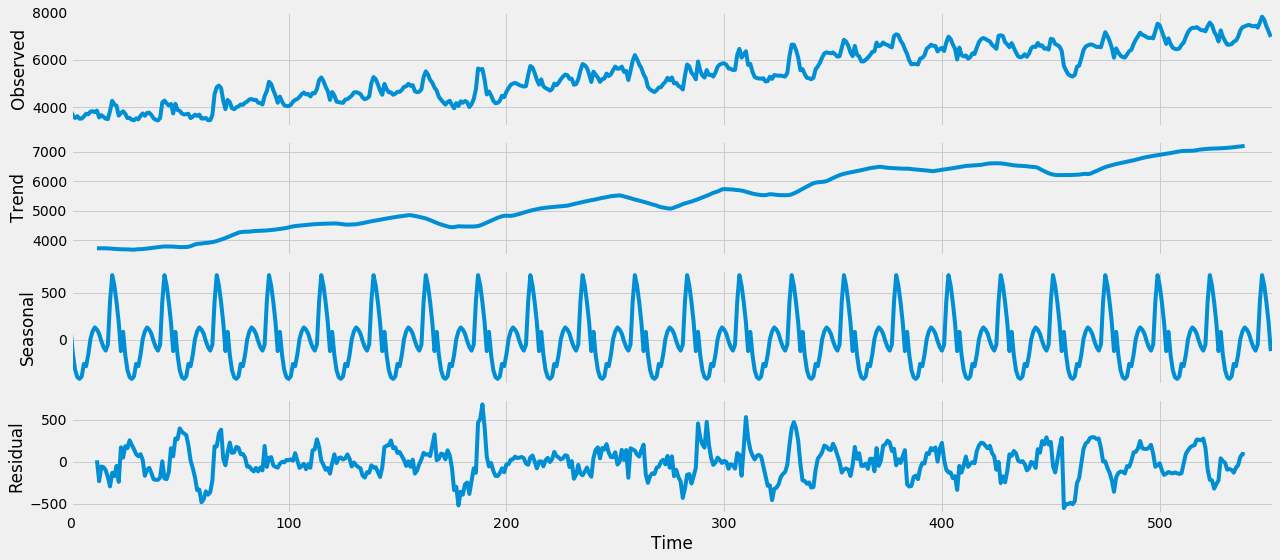

In [138]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npvg, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [139]:
vg_train = vg[0:int(ndat)]
vg_test= vg[int(ndat):len(npvg)]

In [306]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(vg_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8799.176811051584
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:8069.047887546294
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:6206.80243382542
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:5852.805655917313
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:6163.247284940027
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:6024.42957499321
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:5857.306234810956
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:5839.92729060758
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8460.717993536458
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7316.197035872167
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:5880.374264564207
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5515.271706493036
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:5869.461592331519
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5638.335887171489
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5523.834540453565
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5497.502102748427
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:5959.747641681139
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5533.620427010924
ARIMA(0, 1, 0

In [140]:
mod_vg = sm.tsa.statespace.SARIMAX(np.array(vg_train, dtype=float),
                                order=(0, 1, 0),
                                seasonal_order=(2, 0, 2, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_vg = mod_vg.fit()
results_vg.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

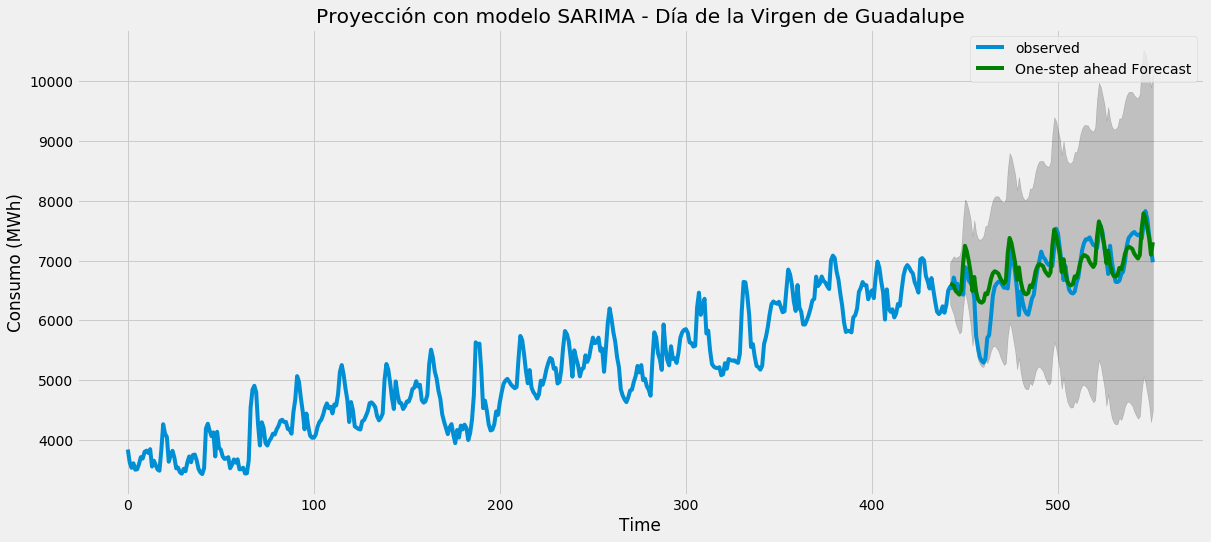

In [141]:
pred_vg_1 = results_vg.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_vg_1.conf_int()
train = np.array(vg, dtype=float)
ax= plt.plot(train, label='observed')
pred_vg= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_vg['Forecast'] = pred_vg_1.predicted_mean
plt.plot(pred_vg,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_vg.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Día de la Virgen de Guadalupe')
plt.legend()
plt.show()

In [142]:
errores[names[11]]['SARIMA'] = abs(np.mean((np.asarray(vg_test['MWh'].tolist())-np.asarray(pred_vg['Forecast'].tolist()))/np.asarray(pred_vg['Forecast'].tolist())))

#### <p style="text-align: center">  <font color = 'red'> Navidad

In [143]:
nav = data[(data.Day == names[12])].drop(['Day'], axis =1)

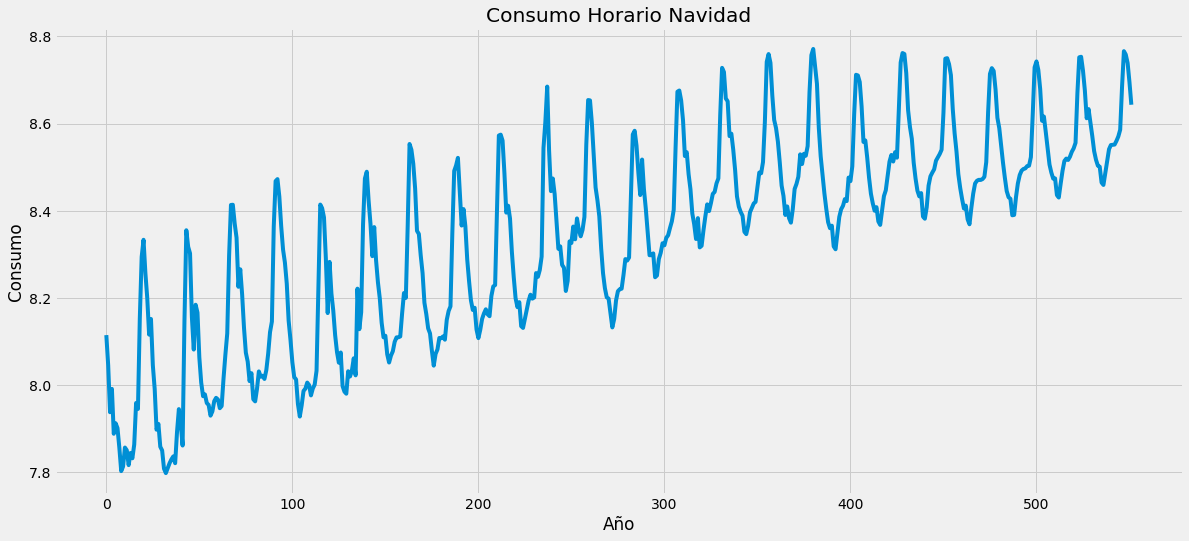

In [144]:
npnav = np.array(nav, dtype=float)
ndat = np.round(0.80*len(npnav))
series_nav = np.log(npnav)
plt.plot(series_nav)
plt.xlabel('Año')
plt.ylabel('Consumo')
plt.title('Consumo Horario Navidad')
plt.show()

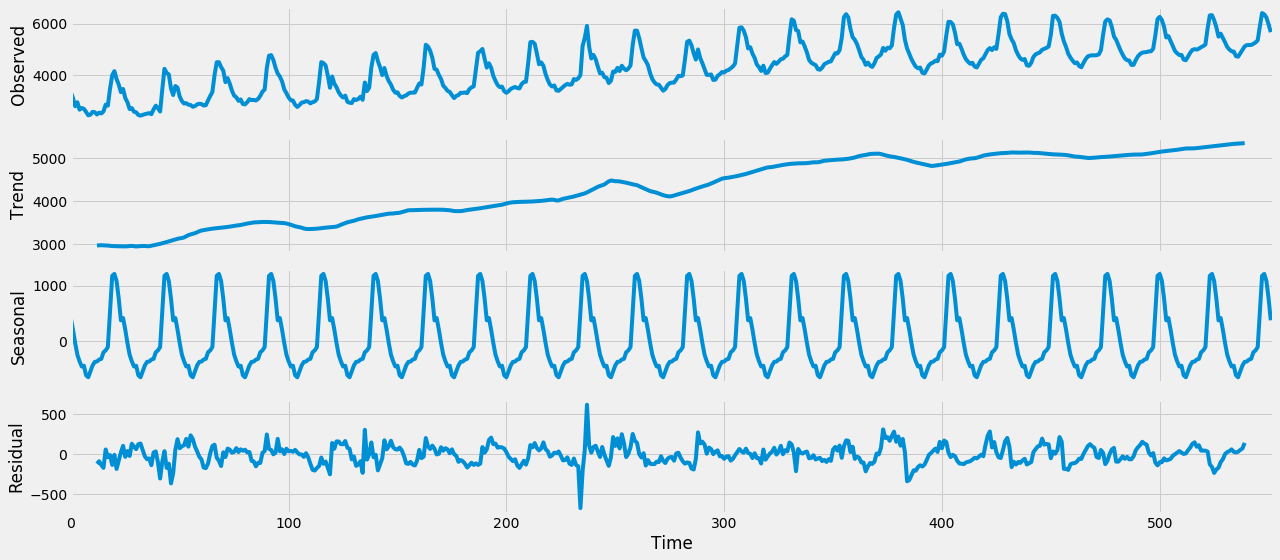

In [145]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(npnav, model='additive',
                                         freq=24)
fig = decomposition.plot()
plt.show()

In [146]:
n_train =nav[0:int(ndat)]
n_test=nav[int(ndat):len(npnav)]

In [314]:
parameters = pd.DataFrame(columns=['param','param_seasonal','results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(np.array(n_train, dtype=float),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))



ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:8608.519240946804
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:7884.8033128012485
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:5908.041353962507
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:5573.88981310328
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:5854.262297130604
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:5717.361191571511
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:5581.408749258919
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:5558.354255568028
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:8267.735966150804
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:7112.622367327375
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:5649.493546943351
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:5291.789555737283
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:5633.239740524734
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:5448.466397364386
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:5305.368234470017
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:5272.560789433723
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:6156.767405278026
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:5626.21532454858
ARIMA(0, 1,

In [147]:
mod_n = sm.tsa.statespace.SARIMAX(np.array(nav, dtype=float),
                                order=(0, 0,1),
                                seasonal_order=(0, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_n = mod_n.fit()
results_n.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

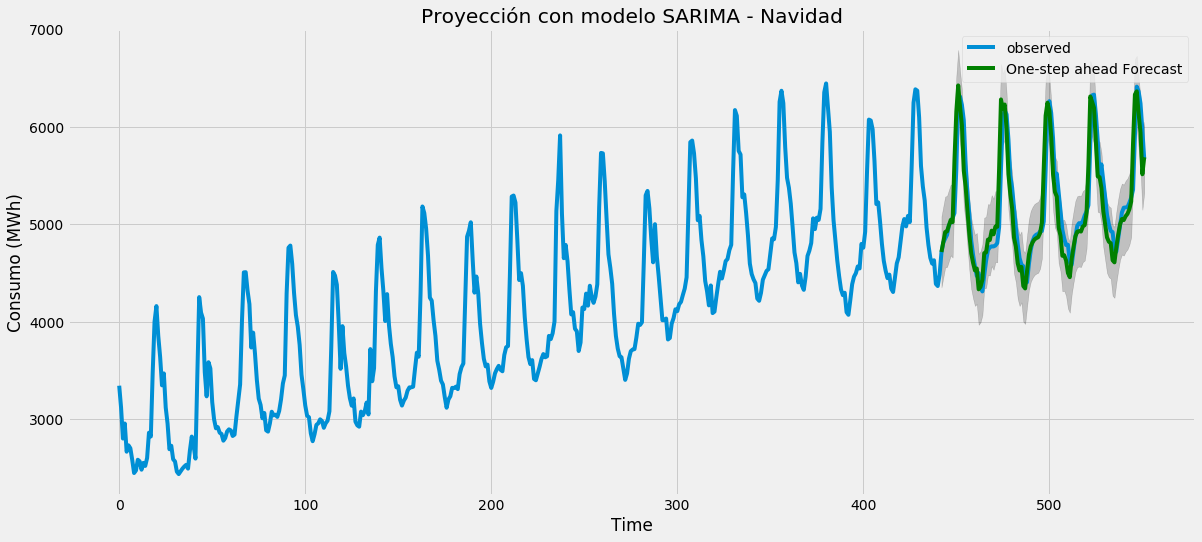

In [148]:
pred_n_1 = results_n.get_prediction(start = int(ndat)+1 , end = len(a_nuevo))
pred_ci = pred_n_1.conf_int()
train = np.array(nav, dtype=float)
ax= plt.plot(train, label='observed')
pred_n= pd.DataFrame(index= range(int(ndat),len(a_nuevo)),columns=['Forecast'])
pred_n['Forecast'] = pred_n_1.predicted_mean
plt.plot(pred_n,color='g', label='One-step ahead Forecast')
plt.fill_between(pred_n.index,pred_ci[:, 1],
                pred_ci[:, 0], color='k', alpha=.2)
plt.xlabel('Time')
plt.ylabel('Consumo (MWh)')
plt.title('Proyección con modelo SARIMA - Navidad')
plt.legend()
plt.show()

In [149]:
errores[names[12]]['SARIMA'] = abs(np.mean((np.asarray(vg_test['MWh'].tolist())-np.asarray(pred_vg['Forecast'].tolist()))/np.asarray(pred_vg['Forecast'].tolist())))

## <p style="text-align: center"> Errores

In [150]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [151]:
errores.style.apply(highlight_min)

### <p style="text-align: center"> Gráficas

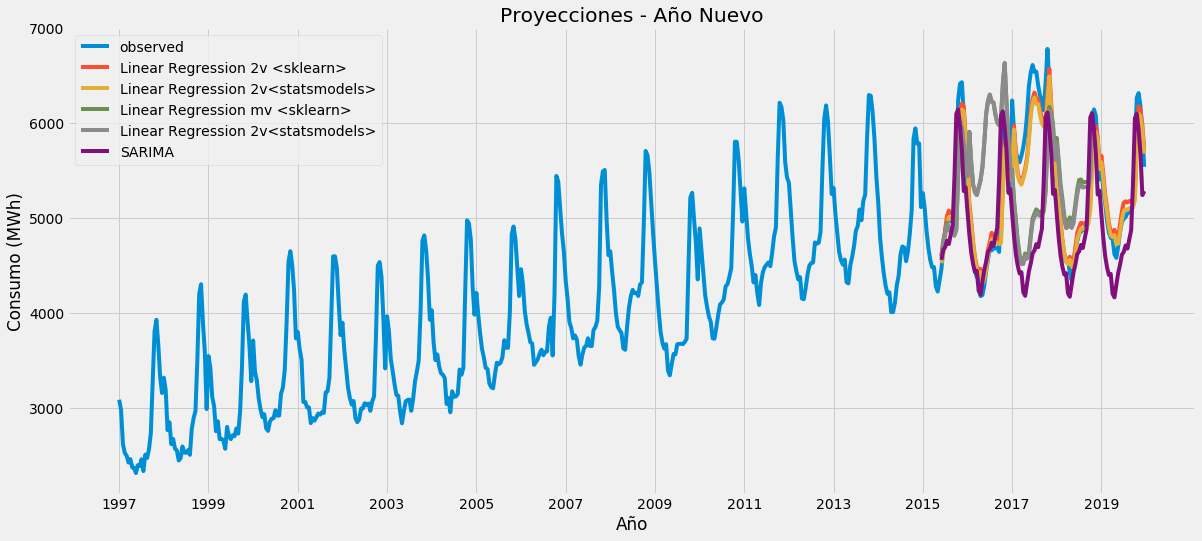

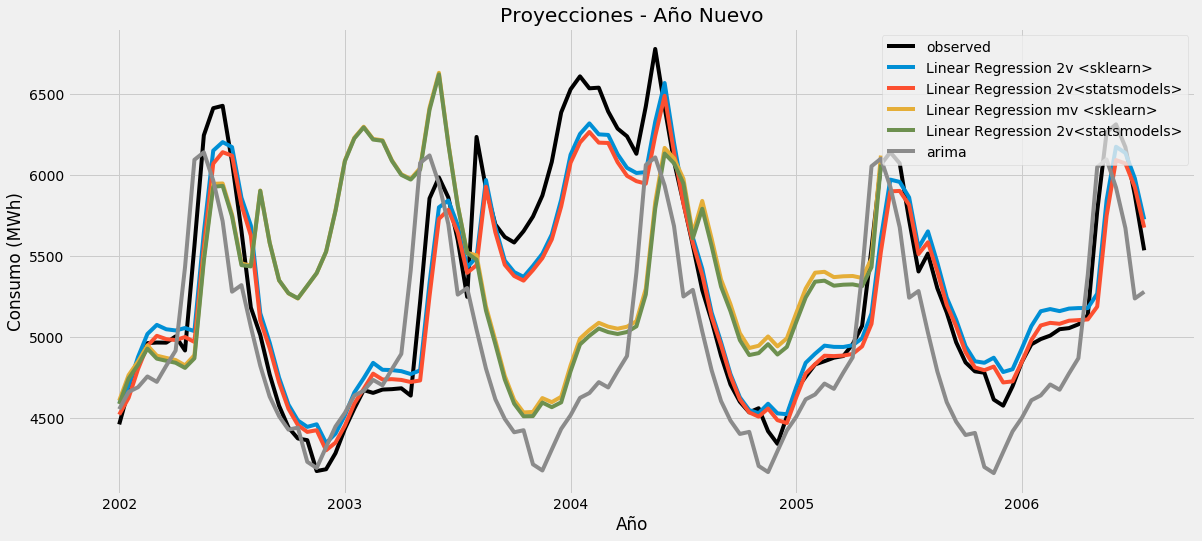

In [152]:
ax= plt.plot(np.array(a_nuevo['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_an0= pd.DataFrame(columns = ['1','2','3','4'])
#lin_reg_an0 = lin_reg_an0.set_index(np.arange(442,442+len(pred_lr1)))
lin_reg_an0['1']= pred_lr1[names[0]]
lin_reg_an0['2']= pred_lr2[names[0]]
lin_reg_an0['3']= pred_lr3[names[0]]
lin_reg_an0['4']= pred_lr4[names[0]]
lin_reg_an0['arima'] = np.array(pred_an)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_an0 =lin_reg_an0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_an0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_an0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_an0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_an0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_an0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Año Nuevo')
plt.legend()
plt.show()

ax= plt.plot(np.array(a_nuevo[int(ndat):len(npa_nuevo)], dtype=float),color = 'k', label='observed')
pred_an = pred_an.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_an = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_an['1']= pred_lr1[names[0]]
lin_reg_an['2']= pred_lr2[names[0]]
lin_reg_an['3']= pred_lr3[names[0]]
lin_reg_an['4']= pred_lr4[names[0]]
lin_reg_an['arima'] = np.array(pred_an)
plt.plot(lin_reg_an['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_an['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_an['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_an['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_an['arima'],label='arima')
plt.plot

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Año Nuevo')
plt.legend()
plt.show()

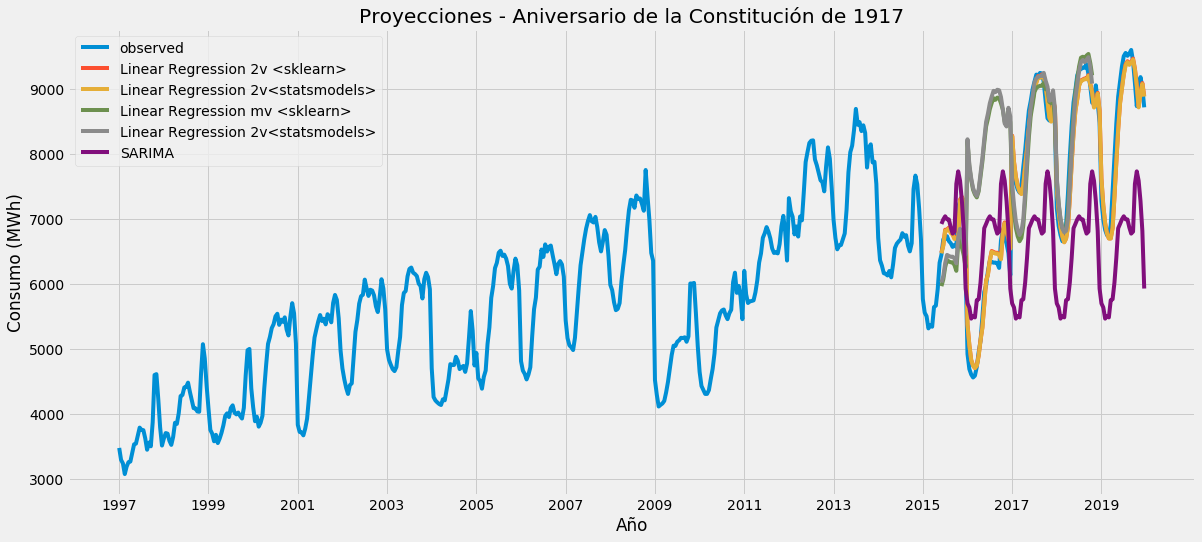

In [155]:
ax= plt.plot(np.array(a_const['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_ac0= pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_ac0['1']= pred_lr1[names[1]]
lin_reg_ac0['2']= pred_lr2[names[1]]
lin_reg_ac0['3']= pred_lr3[names[1]]
lin_reg_ac0['4']= pred_lr4[names[1]]
lin_reg_ac0['arima'] = np.array(pred_ac)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_ac0 =lin_reg_ac0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_ac0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_ac0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_ac0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_ac0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_ac0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Aniversario de la Constitución de 1917')
plt.legend()
plt.show()



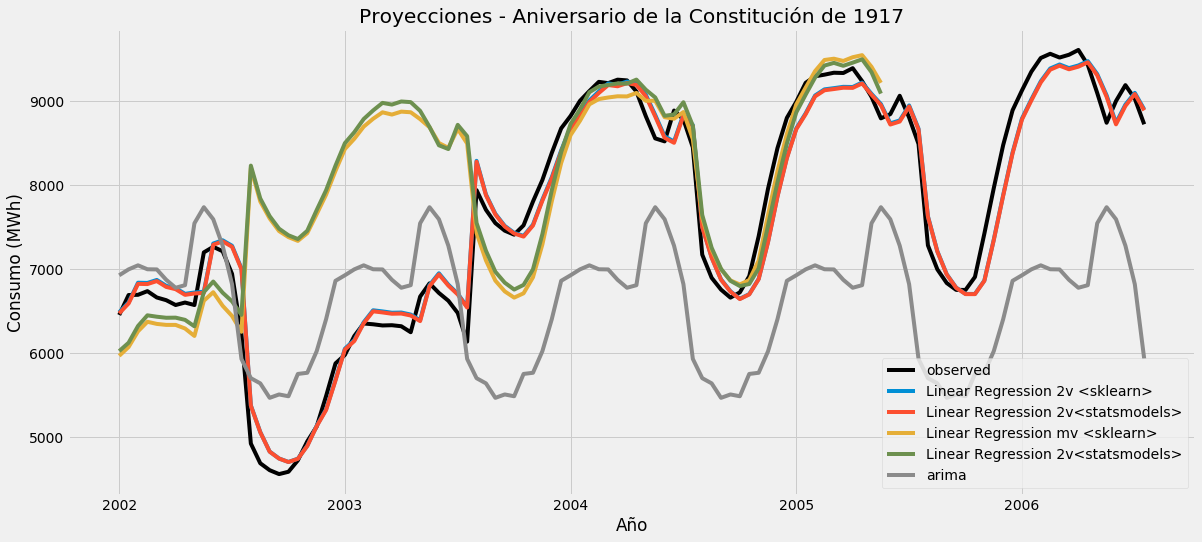

In [156]:
plt.plot(np.array(a_const[int(ndat):len(npa_nuevo)]['MWh'], dtype=float),color = 'k', label='observed')
pred_ac = pred_ac.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_ac = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_ac['1']= pred_lr1[names[1]]
lin_reg_ac['2']= pred_lr2[names[1]]
lin_reg_ac['3']= pred_lr3[names[1]]
lin_reg_ac['4']= pred_lr4[names[1]]
lin_reg_ac['arima'] = np.array(pred_ac)
plt.plot(lin_reg_ac['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_ac['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_ac['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_ac['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_ac['arima'],label='arima')

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Aniversario de la Constitución de 1917')
plt.legend()
plt.show()

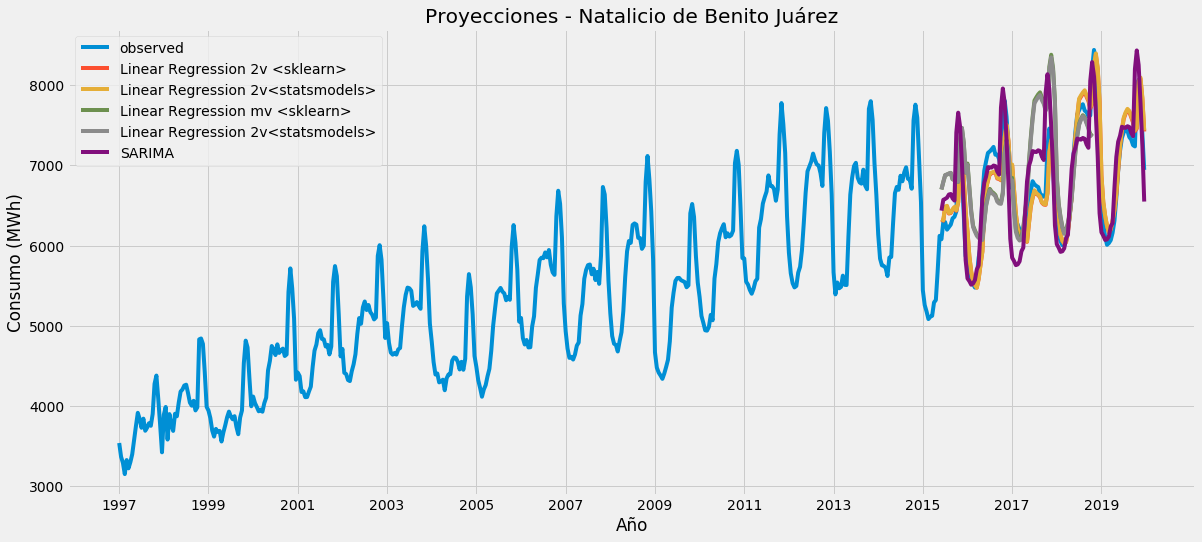

In [157]:
ax= plt.plot(np.array(nat_bj['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_bj0= pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_bj0['1']= pred_lr1[names[2]]
lin_reg_bj0['2']= pred_lr2[names[2]]
lin_reg_bj0['3']= pred_lr3[names[2]]
lin_reg_bj0['4']= pred_lr4[names[2]]
lin_reg_bj0['arima'] = np.array(pred_bj)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_bj0 =lin_reg_bj0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_bj0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_bj0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_bj0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_bj0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_bj0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Natalicio de Benito Juárez')
plt.legend()
plt.show()




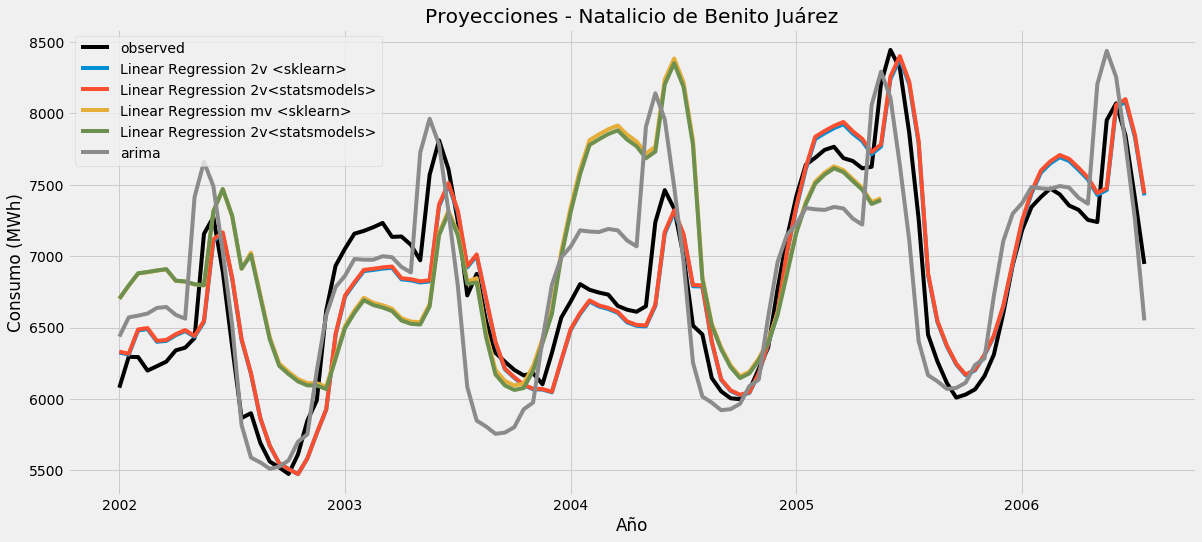

In [158]:
plt.plot(np.array(nat_bj[int(ndat):len(npa_nuevo)]['MWh'], dtype=float),color = 'k', label='observed')
pred_bj = pred_bj.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_bj = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_bj['1']= pred_lr1[names[2]]
lin_reg_bj['2']= pred_lr2[names[2]]
lin_reg_bj['3']= pred_lr3[names[2]]
lin_reg_bj['4']= pred_lr4[names[2]]
lin_reg_bj['arima'] = np.array(pred_bj)
plt.plot(lin_reg_bj['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_bj['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_bj['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_bj['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_bj['arima'],label='arima')

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Natalicio de Benito Juárez')
plt.legend()
plt.show()

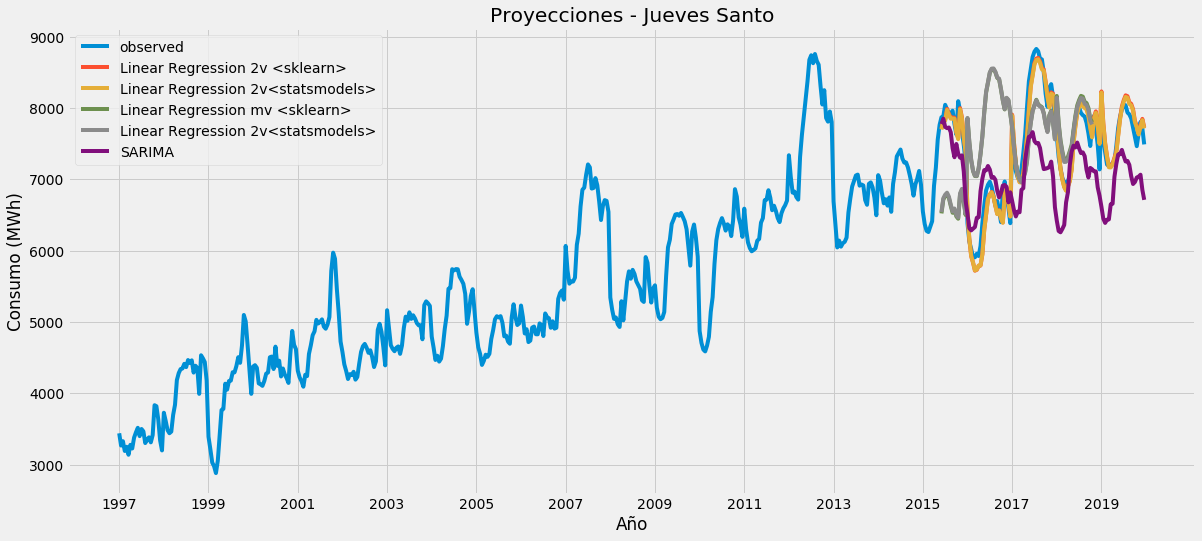

In [159]:
ax= plt.plot(np.array(js['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_js0= pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_js0['1']= pred_lr1[names[3]]
lin_reg_js0['2']= pred_lr2[names[3]]
lin_reg_js0['3']= pred_lr3[names[3]]
lin_reg_js0['4']= pred_lr4[names[3]]
lin_reg_js0['arima'] = np.array(pred_js)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_js0 =lin_reg_js0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_js0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_js0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_js0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_js0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_js0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Jueves Santo')
plt.legend()
plt.show()


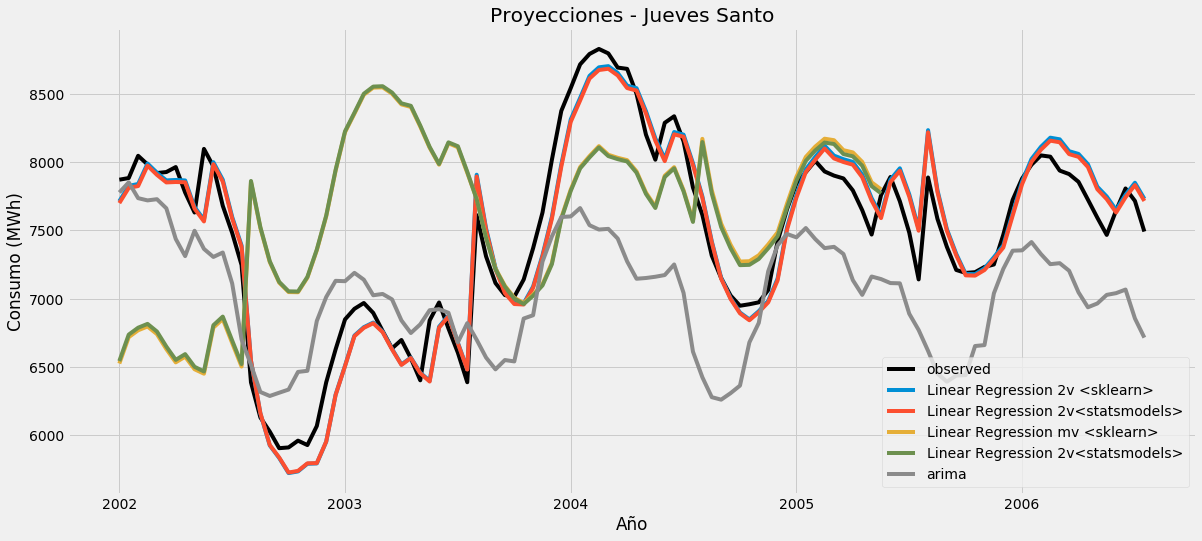

In [160]:
plt.plot(np.array(js[int(ndat):len(npa_nuevo)]['MWh'], dtype=float),color = 'k', label='observed')
pred_js = pred_js.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_js = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_js['1']= pred_lr1[names[3]]
lin_reg_js['2']= pred_lr2[names[3]]
lin_reg_js['3']= pred_lr3[names[3]]
lin_reg_js['4']= pred_lr4[names[3]]
lin_reg_js['arima'] = np.array(pred_js)
plt.plot(lin_reg_js['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_js['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_js['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_js['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_js['arima'],label='arima')

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Jueves Santo')
plt.legend()
plt.show()

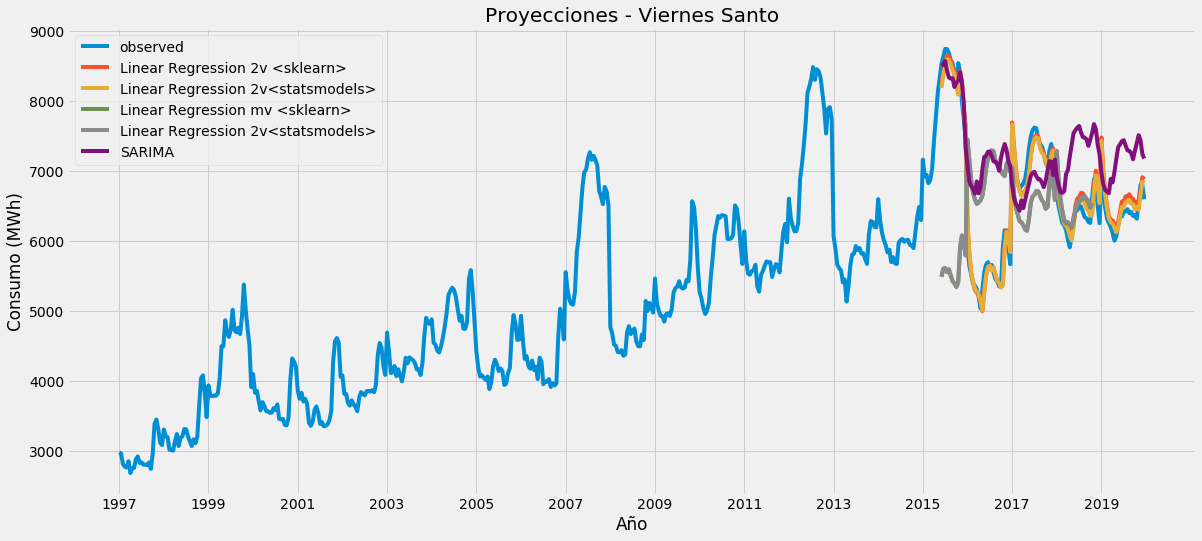

In [162]:
ax= plt.plot(np.array(vs['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_vs0= pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_vs0['1']= pred_lr1[names[4]]
lin_reg_vs0['2']= pred_lr2[names[4]]
lin_reg_vs0['3']= pred_lr3[names[4]]
lin_reg_vs0['4']= pred_lr4[names[4]]
lin_reg_vs0['arima'] = np.array(pred_vs)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_vs0 =lin_reg_vs0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_vs0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_vs0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_vs0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_vs0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_vs0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Viernes Santo')
plt.legend()
plt.show()

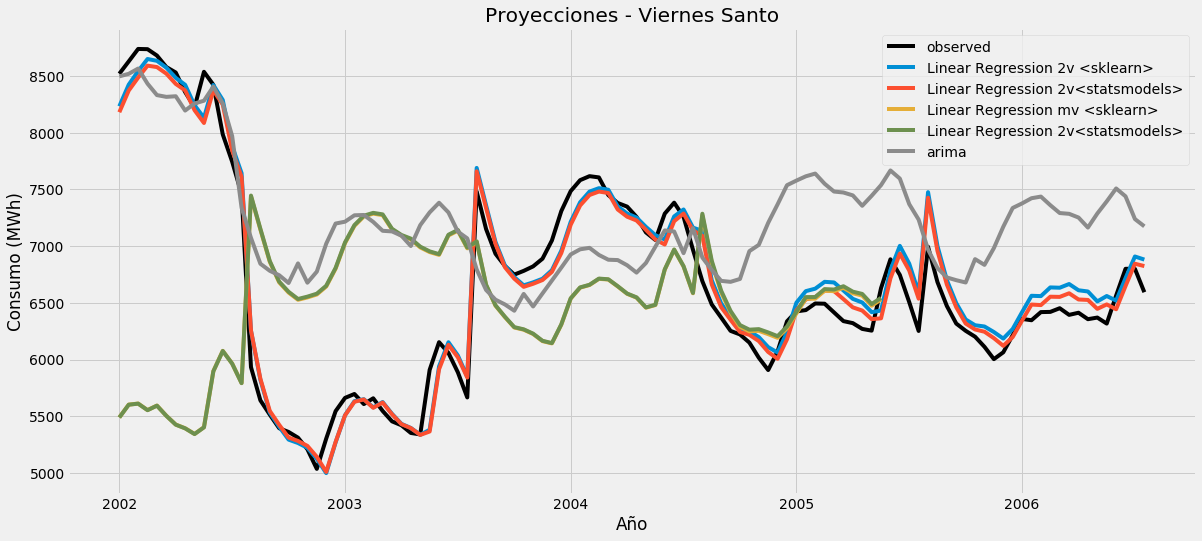

In [165]:
plt.plot(np.array(vs[int(ndat):len(npa_nuevo)]['MWh'], dtype=float),color = 'k', label='observed')
pred_vs = pred_vs.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_vs = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_vs['1']= pred_lr1[names[4]]
lin_reg_vs['2']= pred_lr2[names[4]]
lin_reg_vs['3']= pred_lr3[names[4]]
lin_reg_vs['4']= pred_lr4[names[4]]
lin_reg_vs['arima'] = np.array(pred_vs)
plt.plot(lin_reg_vs['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_vs['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_vs['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_vs['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_vs['arima'],label='arima')

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Viernes Santo')
plt.legend()
plt.show()

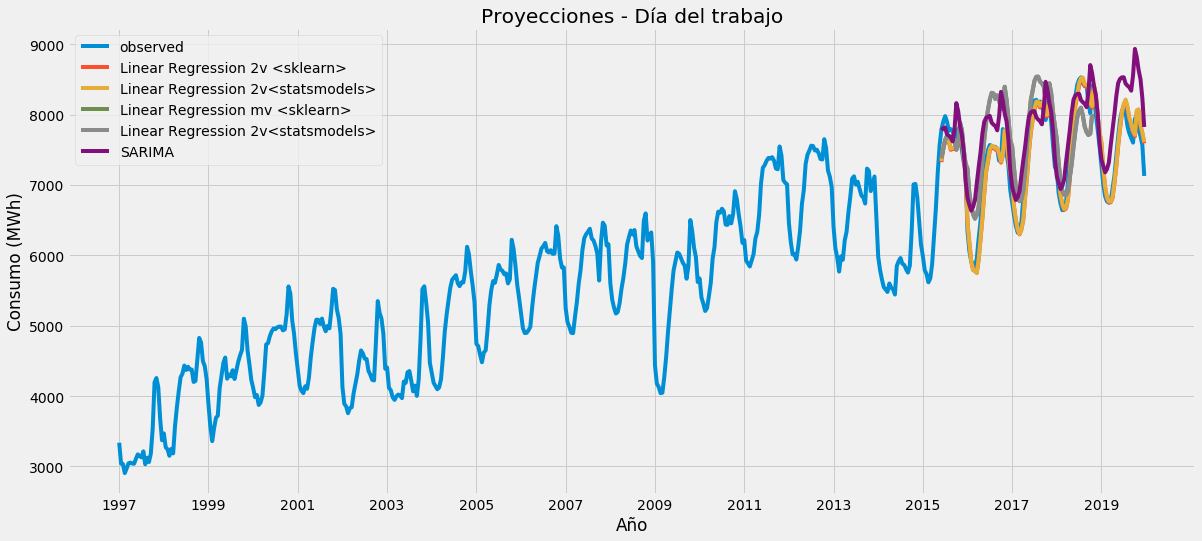

In [166]:
ax= plt.plot(np.array(dt['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_dt0= pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_dt0['1']= pred_lr1[names[5]]
lin_reg_dt0['2']= pred_lr2[names[5]]
lin_reg_dt0['3']= pred_lr3[names[5]]
lin_reg_dt0['4']= pred_lr4[names[5]]
lin_reg_dt0['arima'] = np.array(pred_dt)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_dt0 =lin_reg_dt0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_dt0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_dt0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dt0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_dt0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dt0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Día del trabajo')
plt.legend()
plt.show()

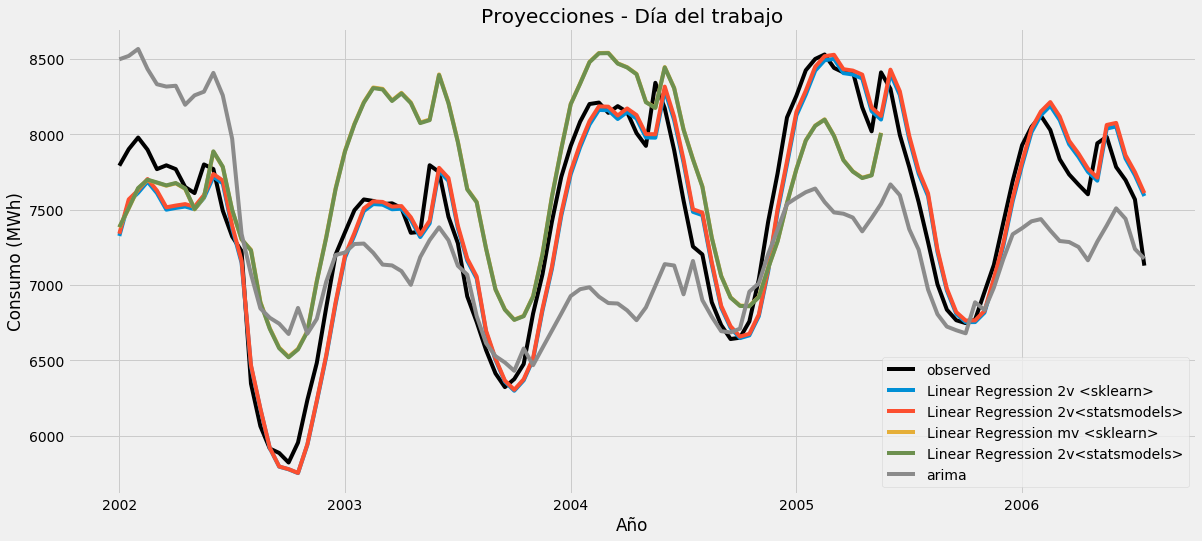

In [167]:
plt.plot(np.array(dt[int(ndat):len(npa_nuevo)]['MWh'], dtype=float),color = 'k', label='observed')
pred_dt = pred_vs.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_dt = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_dt['1']= pred_lr1[names[5]]
lin_reg_dt['2']= pred_lr2[names[5]]
lin_reg_dt['3']= pred_lr3[names[5]]
lin_reg_dt['4']= pred_lr4[names[5]]
lin_reg_dt['arima'] = np.array(pred_dt)
plt.plot(lin_reg_dt['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_dt['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dt['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_dt['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dt['arima'],label='arima')

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Día del trabajo')
plt.legend()
plt.show()

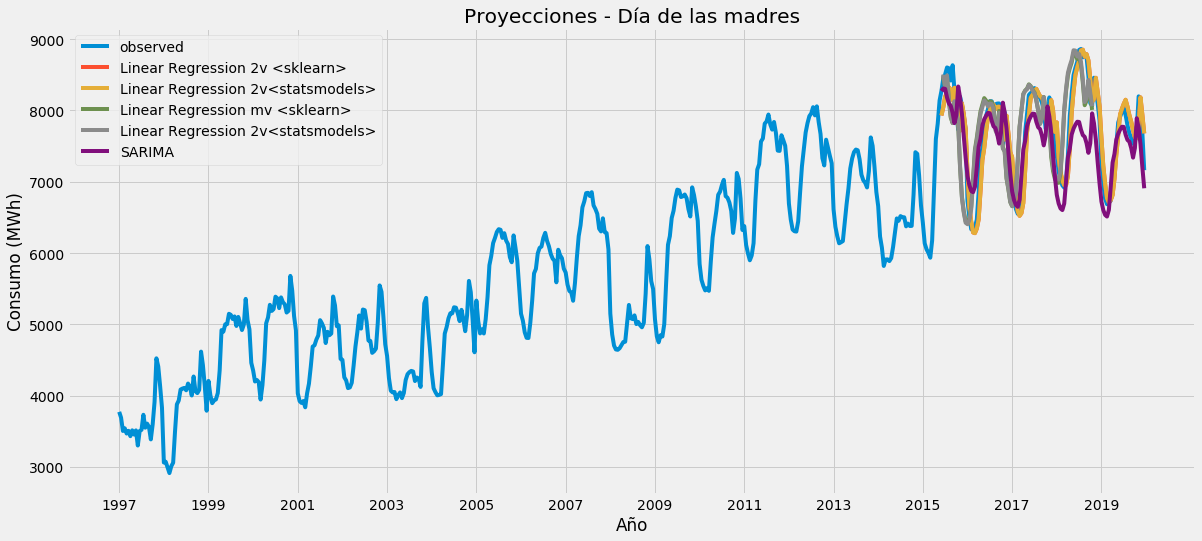

In [168]:
ax= plt.plot(np.array(dm['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_dm0= pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_dm0['1']= pred_lr1[names[6]]
lin_reg_dm0['2']= pred_lr2[names[6]]
lin_reg_dm0['3']= pred_lr3[names[6]]
lin_reg_dm0['4']= pred_lr4[names[6]]
lin_reg_dm0['arima'] = np.array(pred_dm)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_dm0 =lin_reg_dm0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_dm0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_dm0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dm0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_dm0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dm0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Día de las madres')
plt.legend()
plt.show()

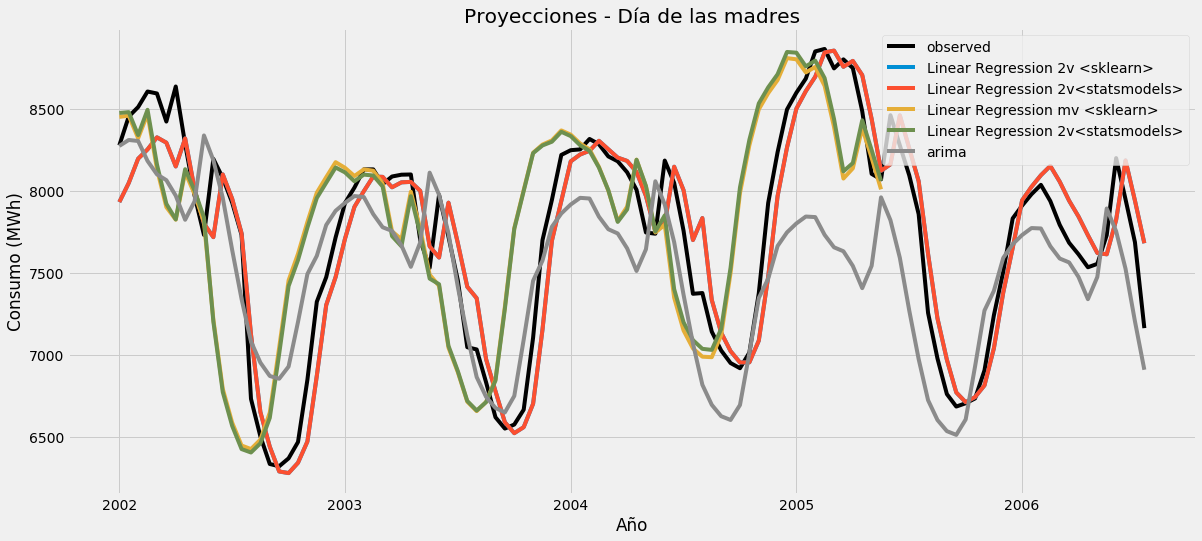

In [169]:
plt.plot(np.array(dm[int(ndat):len(npa_nuevo)]['MWh'], dtype=float),color = 'k', label='observed')
pred_dm = pred_dm.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_dm = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_dm['1']= pred_lr1[names[6]]
lin_reg_dm['2']= pred_lr2[names[6]]
lin_reg_dm['3']= pred_lr3[names[6]]
lin_reg_dm['4']= pred_lr4[names[6]]
lin_reg_dm['arima'] = np.array(pred_dm)
plt.plot(lin_reg_dm['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_dm['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dm['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_dm['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_dm['arima'],label='arima')

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Día de las madres')
plt.legend()
plt.show()

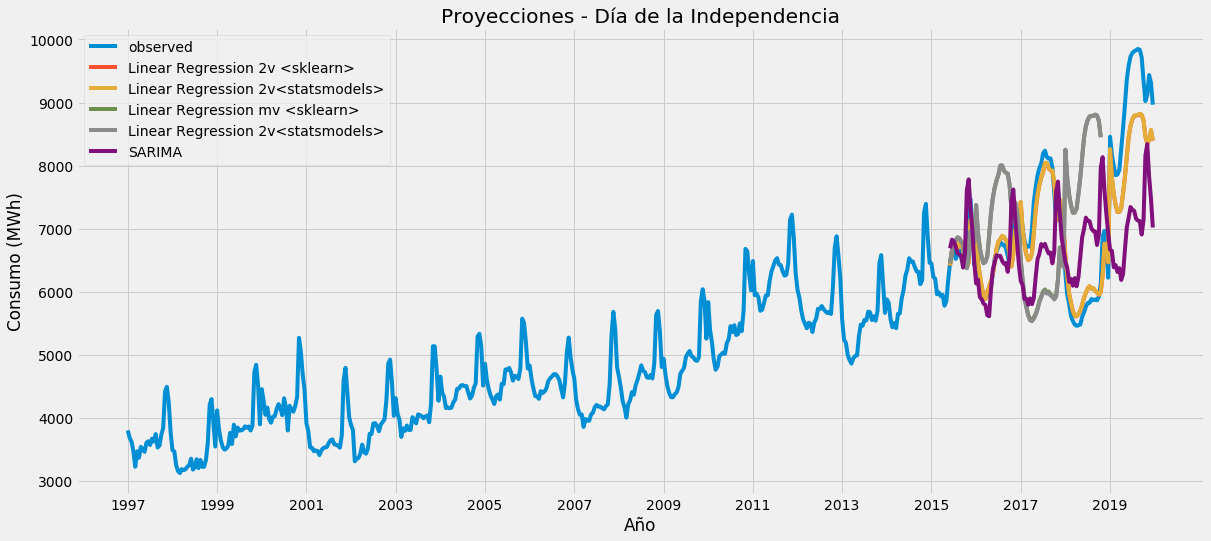

In [173]:
ax= plt.plot(np.array(di['MWh'], dtype=float), label='observed')

#plt.plot(pred_an,color='g', label='Arima')
lin_reg_di0= pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_di0['1']= pred_lr1[names[7]]
lin_reg_di0['2']= pred_lr2[names[7]]
lin_reg_di0['3']= pred_lr3[names[7]]
lin_reg_di0['4']= pred_lr4[names[7]]
lin_reg_di0['arima'] = np.array(pred_di)
#lin_reg_an0=lin_reg_an0.set_index(a_nuevo.index[442:])
lin_reg_di0 =lin_reg_di0.set_index(np.arange(int(ndat),len(a_nuevo)))
plt.plot(lin_reg_di0['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_di0['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_di0['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_di0['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_di0['arima'],label='SARIMA')

plt.xticks(np.arange(0, 552, step=48),np.arange(1997,2020,step =2)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Día de la Independencia')
plt.legend()
plt.show()

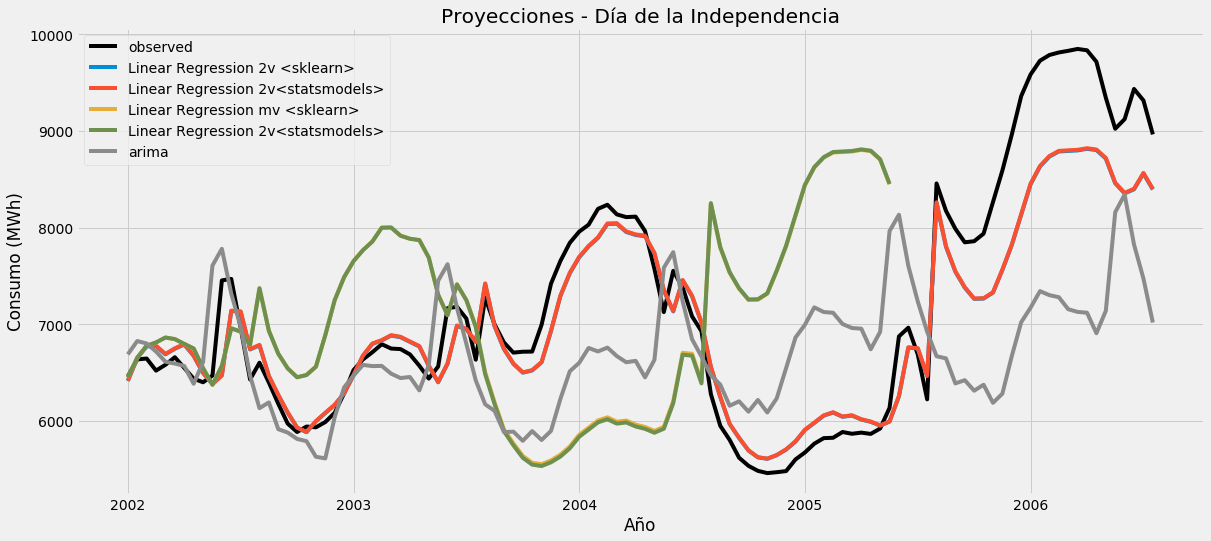

In [171]:
plt.plot(np.array(di[int(ndat):len(npa_nuevo)]['MWh'], dtype=float),color = 'k', label='observed')
pred_di = pred_di.set_index(np.arange(0,110))
#plt.plot(pred_an['Forecast'],color='g', label='Arima')
lin_reg_di = pd.DataFrame(columns = ['1','2','3','4'])
lin_reg_di['1']= pred_lr1[names[7]]
lin_reg_di['2']= pred_lr2[names[7]]
lin_reg_di['3']= pred_lr3[names[7]]
lin_reg_di['4']= pred_lr4[names[7]]
lin_reg_di['arima'] = np.array(pred_di)
plt.plot(lin_reg_di['1'],label='Linear Regression 2v <sklearn>')
plt.plot(lin_reg_di['2'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_di['3'],label='Linear Regression mv <sklearn>')
plt.plot(lin_reg_di['4'],label='Linear Regression 2v<statsmodels>')
plt.plot(lin_reg_di['arima'],label='arima')

plt.xticks(np.arange(0, 110, step=24),np.arange(2002,2020,step =1)) 
plt.xlabel('Año')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Día de la Independencia')
plt.legend()
plt.show()